# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Подготовка данных

In [61]:
!pip install sklearn
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
data = pd.read_csv("Churn.csv")
display(data)
data.info()

#Удалим ненужные столбцы 
data = data.drop(["RowNumber"], axis = 1)

#На всякий случай скопируем таблицу в новую переменную
data2 = data.copy()

#Создадим дамми-признаки для столбцов с категориальными переменными
data2 = pd.get_dummies(data2, columns = ["Geography", "Gender"], drop_first = True) 

#Удалим оставшиеся не нужные столбцы
data2 = data2.drop(["CustomerId", "Surname"], axis = 1)

#Получим таблицу с пропущенными значениями
data_nan2 = data2[data2.isnull().any(axis = 1)]

#data2 = data2.dropna().reset_index(drop = True)
#scaler.fit(data2)

data_nan2 = data2[data2.isnull().any(axis = 1)]
display(data_nan2)
data_nan2.info()


#Удалим пропущенные значения
data2 = data2.dropna().reset_index(drop = True)
display(data2)
data2.info()

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0        2.0       0.00              1          1               1   
1        1.0   83807.86              1          0               1   
2        8.0  159660.80              3          1               0   
3        1.0       0.00              2          0               0   
4        2.0  125510.82              1          1               1   
...      ...        ...            ...        ...             ...   
9995     5.0       0.00              2          1               0   
9996    10.0   57369.61              1          1               1   
9997     7.0       0.00              1          0               1   
9998     3.0   75075.31              2          1               0   
9999     NaN  130142.79              1          1               0   

      EstimatedSalary  Exited  
0           101348.88       1  
1           112542.58       0  
2           113931.57       1  
3            93826.63       0  
4            79084.10       0  
...               ...     ...  
9995         96270.64       0  
9996        101699.77       0  
9997         42085.58       1  
9998         92888.52       1  
9999         38190.78       0  

[10000 rows x 14 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
30            591   39     NaN       0.00              3          1   
48            550   38     NaN  103391.38              1          0   
51            585   36     NaN  146050.97              2          0   
53            655   41     NaN  125561.97              1          0   
60            742   35     NaN  136857.00              1          0   
...           ...  ...     ...        ...            ...        ...   
9944          744   41     NaN  190409.34              2          1   
9956          520   46     NaN   85216.61              1          1   
9964          479   34     NaN  117593.48              2          0   
9985          659   36     NaN  123841.49              2          1   
9999          792   28     NaN  130142.79              1          1   

      IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
30                 0        140469.38       1                  0   
48                 1         90878.13       0                  1   
51                 0         86424.57       0                  1   
53                 0        164040.94       1                  1   
60                 0         84509.57       0                  1   
...              ...              ...     ...                ...   
9944               1        138361.48       0                  1   
9956               0        117369.52       1                  0   
9964               0        113308.29       0                  0   
9985               0         96833.00       0                  0   
9999               0         38190.78       0                  0   

      Geography_Spain  Gender_Male  
30                  1            0  
48                  0            1  
51                  0            1  
53                  0            1  
60                  0            1  
...               ...          ...  
9944                0            1  
9956                0            0  
9964                0            1  
9985                0            1  
9999                0            0  

[909 rows x 12 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 909 entries, 30 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        909 non-null    int64  
 1   Age                909 non-null    int64  
 2   Tenure             0 non-null      float64
 3   Balance            909 non-null    float64
 4   NumOfProducts      909 non-null    int64  
 5   HasCrCard          909 non-null    int64  
 6   IsActiveMember     909 non-null    int64  
 7   EstimatedSalary    909 non-null    float64
 8   Exited             909 non-null    int64  
 9   Geography_Germany  909 non-null    uint8  
 10  Geography_Spain    909 non-null    uint8  
 11  Gender_Male        909 non-null    uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 73.7 KB


CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0             619   42     2.0       0.00              1          1   
1             608   41     1.0   83807.86              1          0   
2             502   42     8.0  159660.80              3          1   
3             699   39     1.0       0.00              2          0   
4             850   43     2.0  125510.82              1          1   
...           ...  ...     ...        ...            ...        ...   
9086          800   29     2.0       0.00              2          0   
9087          771   39     5.0       0.00              2          1   
9088          516   35    10.0   57369.61              1          1   
9089          709   36     7.0       0.00              1          0   
9090          772   42     3.0   75075.31              2          1   

      IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0                  1        101348.88       1                  0   
1                  1        112542.58       0                  0   
2                  0        113931.57       1                  0   
3                  0         93826.63       0                  0   
4                  1         79084.10       0                  0   
...              ...              ...     ...                ...   
9086               0        167773.55       0                  0   
9087               0         96270.64       0                  0   
9088               1        101699.77       0                  0   
9089               1         42085.58       1                  0   
9090               0         92888.52       1                  1   

      Geography_Spain  Gender_Male  
0                   0            0  
1                   1            0  
2                   0            0  
3                   0            0  
4                   1            0  
...               ...          ...  
9086                0            0  
9087                0            1  
9088                0            1  
9089                0            0  
9090                0            1  

[9091 rows x 12 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        9091 non-null   int64  
 1   Age                9091 non-null   int64  
 2   Tenure             9091 non-null   float64
 3   Balance            9091 non-null   float64
 4   NumOfProducts      9091 non-null   int64  
 5   HasCrCard          9091 non-null   int64  
 6   IsActiveMember     9091 non-null   int64  
 7   EstimatedSalary    9091 non-null   float64
 8   Exited             9091 non-null   int64  
 9   Geography_Germany  9091 non-null   uint8  
 10  Geography_Spain    9091 non-null   uint8  
 11  Gender_Male        9091 non-null   uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 666.0 KB


# Вывод:


1. Удалили 3 бесполезных для нас столбца с номером строки("RowNumber"), уникальным идентификатором("CostumerId") и фамилией("Surname").


2. Получили дамми-признаки для столбцов с категориальными переменным("Georgaphy", "Gender").
    
    2.1 one-hot-encoding вместо ordinalencoder, потому что с применением OHE результаты на тестах были лучше.
    
    
3. В таблице есть пропущенные значения, в столбце "Tenure", чтобы их заполнить, я решил выделить все строки с пропусками в
    отдельную таблицу, и потом, используя методы машинного обучения предсказать значения в столбце на основе, имеющих данных.
    
   
4. Стандартизируем данные в столбцах с количественными переменными и объеденим эту таблицу с остальными столбцами.


Признаки:

RowNumber — индекс строки в данных

CustomerId — уникальный идентификатор клиента

Surname — фамилия

CreditScore — кредитный рейтинг

Geography — страна проживания

Gender — пол

Age — возраст

Tenure — сколько лет человек является клиентом банка

Balance — баланс на счёте

NumOfProducts — количество продуктов банка, используемых клиентом

HasCrCard — наличие кредитной карты

IsActiveMember — активность клиента

EstimatedSalary — предполагаемая зарплата

Целевой признак:
Exited — факт ухода клиента

Здесь проверим данные на мультиколлинеарность и посмотрим на распределение целевого признака.

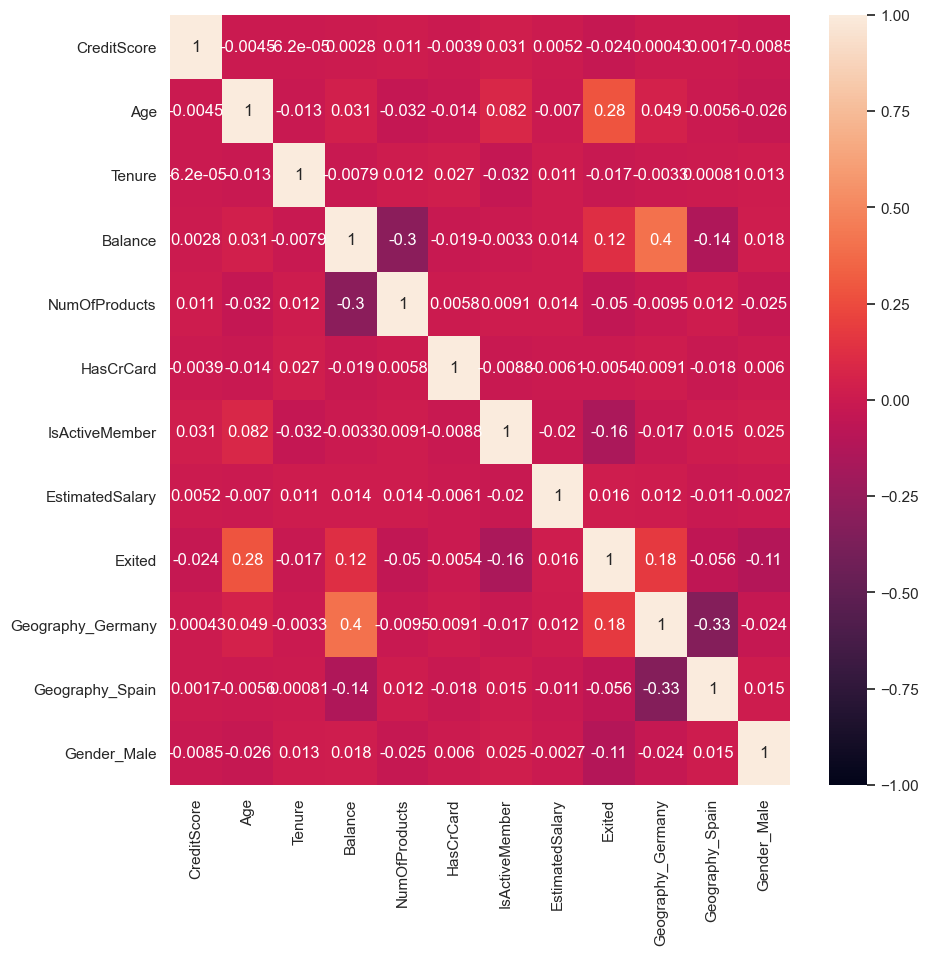

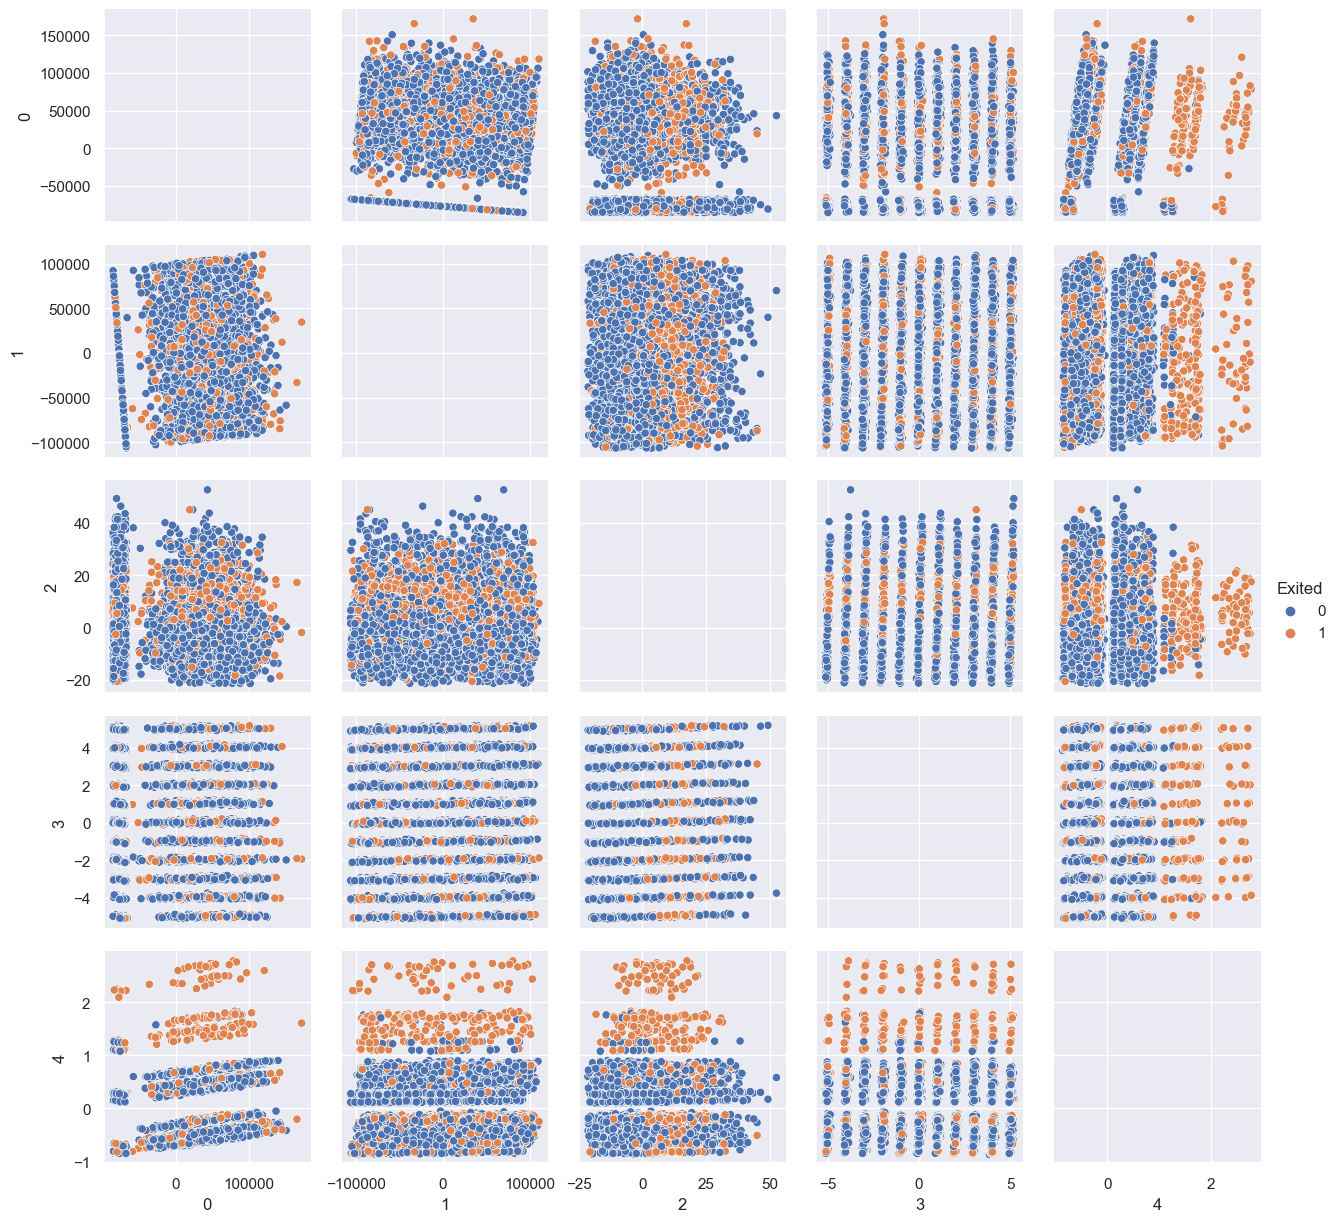

In [63]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
components = pd.DataFrame(pca.fit_transform(data2[data2.columns[1:-1]]))
components["Exited"] = data2["Exited"].reset_index(drop = True)
sns.heatmap(data2.corr(), vmin = -1, vmax = 1, annot = True)
sns.set(rc = {"figure.figsize" : (10, 10)})
plt.show()
g = sns.PairGrid(components, hue = "Exited")
#g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

Как видно из тепловой карты, мультиколлинеарность нам не грозит. А вот с распределением все сложнее. Во-первых: На лицо дисбаланс классов(даже если просто посмотреть, синих точек больше чем оранжевых), а во-вторых: данные довольно грязные, распределение будет не просто разделить на категории, и обычный линейный классификатор без параметров здесь не подойдет.


P.S Я хотел решить эту проблему, используя модель гауссовской смеси, но она так долго генерировала сэмплы, что я не выдержал и решил делать без нее, благо результаты были хорошими.

# Выберем модель для заполнения пропусков

In [64]:
from sklearn import model_selection

#Делим выборку на признаки и целевой признак
features = data2.drop(["Tenure"], axis = 1)
target = data2["Tenure"]

#Получаем тренировочную и валидационную выборки
data_train, data_valid = train_test_split(data2, test_size = 0.25, random_state = 12345)
#print(features_train.shape, target_train.shape)
#data_train.info()
#data_valid.info()

#Стандартизируем столбцы с количественными переменными в тренировочной выборке
data_scaler2 = data_train.drop(["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary"], axis = 1).reset_index(drop = True)
data_scaler = data_train[["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary"]].reset_index(drop = True)
scaler.fit(data_scaler)
data_scaler = pd.DataFrame(scaler.transform(data_scaler), columns = data_scaler.columns)

#Объеденим стандартизированную таблицу с остальными признаками
data_train = data_scaler.join(data_scaler2)
features_train = data_train.drop(["Tenure"], axis = 1)
target_train = data_train["Tenure"]

print("data_train:", features_train.shape, target_train.shape)
#display(data_train)


#display(data_valid)

#display(features_train, target_train)

#features_train.info()

#target_train.info()

#display(features_valid, target_valid)

#print(features_train[0])
#print(target_train[0])
#features_train = features_train.to_numpy().reshape(-1, 1)
#target_train = target_train.to_numpy().reshape(-1, 1).ravel()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6818 entries, 1349 to 4578
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        6818 non-null   int64  
 1   Age                6818 non-null   int64  
 2   Tenure             6818 non-null   float64
 3   Balance            6818 non-null   float64
 4   NumOfProducts      6818 non-null   int64  
 5   HasCrCard          6818 non-null   int64  
 6   IsActiveMember     6818 non-null   int64  
 7   EstimatedSalary    6818 non-null   float64
 8   Exited             6818 non-null   int64  
 9   Geography_Germany  6818 non-null   uint8  
 10  Geography_Spain    6818 non-null   uint8  
 11  Gender_Male        6818 non-null   uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 552.6 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2273 entries, 769 to 8686
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning:

Degrees of freedom <= 0 for slice.



RFC cross_val_score_mean: -0.9729628047810944
ElasticNet cross_val_score_mean: -1.0832194698058666
[-0.28555072  0.04149481  0.14477234 ...  0.33411449 -0.54374456
  0.04149481]
RandomForestRegressor MSE: 1.051881358075261
ElasticNet MSE: 0.9720351950192433
ElasticNet MAE: 0.8427655155076128


CreditScore       Age        Tenure   Balance  EstimatedSalary  \
0      -0.580168  0.035995  6.721914e-17 -1.206852         0.732762   
1      -0.994205 -0.066254  6.721914e-17  0.432434        -0.147342   
2      -0.640759 -0.270752  6.721914e-17  1.108809        -0.226380   
3       0.066134  0.240493  6.721914e-17  0.783952         1.151091   
4       0.944702 -0.373000  6.721914e-17  0.963037        -0.260365   
..           ...       ...           ...       ...              ...   
904     0.964899  0.240493  6.721914e-17  1.812117         0.695353   
905    -1.297159  0.751738  6.721914e-17  0.144270         0.322805   
906    -1.711197 -0.475249  6.721914e-17  0.657611         0.250730   
907     0.106528 -0.270752  6.721914e-17  0.756674        -0.041659   
908     1.449625 -1.088743  6.721914e-17  0.856582        -1.082392   

     NumOfProducts  HasCrCard  IsActiveMember  Exited  Geography_Germany  \
0                3          1               0       1                  0   
1                1          0               1       0                  1   
2                2          0               0       0                  1   
3                1          0               0       1                  1   
4                1          0               0       0                  1   
..             ...        ...             ...     ...                ...   
904              2          1               1       0                  1   
905              1          1               0       1                  0   
906              2          0               0       0                  0   
907              2          1               0       0                  0   
908              1          1               0       0                  0   

     Geography_Spain  Gender_Male  
0                  1            0  
1                  0            1  
2                  0            1  
3                  0            1  
4                  0            1  
..               ...          ...  
904                0            1  
905                0            0  
906                0            1  
907                0            1  
908                0            0  

[909 rows x 12 columns]

In [ ]:
#Стандартизируем столбцы с количественными переменными в валидационной выборке
data_scaler_valid2 = data_valid.drop(["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary"], axis = 1).reset_index(drop = True)
data_scaler_valid = data_valid[["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary"]].reset_index(drop = True)
data_scaler_valid = pd.DataFrame(scaler.transform(data_scaler_valid), columns = data_scaler_valid.columns)

#Объеденим стандартизированную таблицу с остальными признаками
data_valid = data_scaler_valid.join(data_scaler_valid2)
features_valid = data_valid.drop(["Tenure"], axis = 1)
target_valid = data_valid["Tenure"]

print("data_valid:", features_valid.shape, target_valid.shape)

In [ ]:
#Стандартизируем столбцы с количественными переменными в выборке с пропущенными значениями
data_scaler_nan2 = data_nan2.drop(["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary"], axis = 1).reset_index(drop = True)
data_scaler_nan = data_nan2[["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary"]].reset_index(drop = True)
scaler.fit(data_scaler_nan)
data_scaler_nan = pd.DataFrame(scaler.transform(data_scaler_nan), columns = data_scaler_nan.columns)

#Объеденим стандартизированную таблицу с остальными признаками
data_nan2 = data_scaler_nan.join(data_scaler_nan2)

print("data_nan2:", data_nan2.shape, data_nan2["Age"].mean(), data_nan2["Age"].std())

In [ ]:
#Инициализируем модели
model_elastic = ElasticNet(random_state = 12345)
model = RandomForestRegressor(random_state = 12345, n_estimators = 20, max_depth = 50)


#Обучаем модели на тренировочной выборке
model_elastic.fit(features_train, target_train)
model.fit(features_train, target_train)


#Получаем предсказания для валидационной выборки
#predictions = model_elastic.predict(features_train)
predictions_valid = model_elastic.predict(features_valid)
predict = model.predict(features_valid)


#Проверим модели на кросс-валидации
result = model_selection.cross_val_score(model, features_valid, target_valid, scoring = "neg_mean_squared_error", cv = 5)
result2 = model_selection.cross_val_score(model_elastic, features_valid, target_valid, scoring = "neg_mean_squared_error", cv = 5)
print("RFC cross_val_score_mean:", result2.mean())
print("ElasticNet cross_val_score_mean:", result.mean())
print(predict)
print("RandomForestRegressor MSE:", mean_squared_error(target_valid, predict))
#print("ElasticNet MSE:", mean_squared_error(target_train, predictions))
print("ElasticNet MSE:", mean_squared_error(target_valid, predictions_valid))
print("ElasticNet MAE:", mean_absolute_error(target_valid, predictions_valid))
#print(accuracy_score(target, predictions))


features_nan = data_nan2.drop(["Tenure"], axis = 1)
data_nan2["Tenure"] = model_elastic.predict(features_nan)
display(data_nan2)

#print(data_nan2["Tenure"].value_counts(), data_nan2["Tenure"].min(), data_nan2["Tenure"].max())
#display(data.head(25))

# Вывод:


ElasticNet показала себя лучше, чем RandomForestRegressor, но посмотрев на её предсказания все эти результаты теряют свой смысл, модель почему-то предсказывает одно и тоже число(я пытался гуглить, задавал вопросы на разных форумах, но никто так и не дал правильного ответа), поэтому посмотря на ситуацию с этой стороны, RF все таки лучше)

In [65]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#def build

In [66]:
!pip install tensorflow-addons
#import tensorflow_addons as tfa

Посмотрев на результаты, и оценив еще несколько моделей - я пришел к выводу, что мне недостаточно этого результата, и решил обучить простенькую нейронную сеть с 2 полносвязнными слоями по 264 нейрона и с функцией активации ReLU и еще одним полносвязнными слоем с одним нейроном в качестве выходного слоя. В качестве функции потерь возьмем mse, и в качестве оптимизатора Adam(был выбран эмпирически) с параметром amsgrad.

Epoch 1/100
214/214 - 0s - loss: 1.0144 - mse: 1.0144 - mae: 0.8675 - mape: 271.7704
Epoch 2/100
214/214 - 0s - loss: 0.9990 - mse: 0.9990 - mae: 0.8631 - mape: 232.8059
Epoch 3/100
214/214 - 0s - loss: 0.9984 - mse: 0.9984 - mae: 0.8622 - mape: 206.2594
Epoch 4/100
214/214 - 0s - loss: 0.9917 - mse: 0.9917 - mae: 0.8601 - mape: 212.6652
Epoch 5/100
214/214 - 0s - loss: 0.9841 - mse: 0.9841 - mae: 0.8565 - mape: 230.3147
Epoch 6/100
214/214 - 0s - loss: 0.9821 - mse: 0.9821 - mae: 0.8536 - mape: 223.2613
Epoch 7/100
214/214 - 0s - loss: 0.9804 - mse: 0.9804 - mae: 0.8540 - mape: 236.7619
Epoch 8/100
214/214 - 0s - loss: 0.9760 - mse: 0.9760 - mae: 0.8516 - mape: 246.0511
Epoch 9/100
214/214 - 0s - loss: 0.9684 - mse: 0.9684 - mae: 0.8479 - mape: 251.9099
Epoch 10/100
214/214 - 0s - loss: 0.9657 - mse: 0.9657 - mae: 0.8461 - mape: 260.4296
Epoch 11/100
214/214 - 0s - loss: 0.9628 - mse: 0.9628 - mae: 0.8448 - mape: 262.8539
Epoch 12/100
214/214 - 0s - loss: 0.9511 - mse: 0.9511 - mae: 0

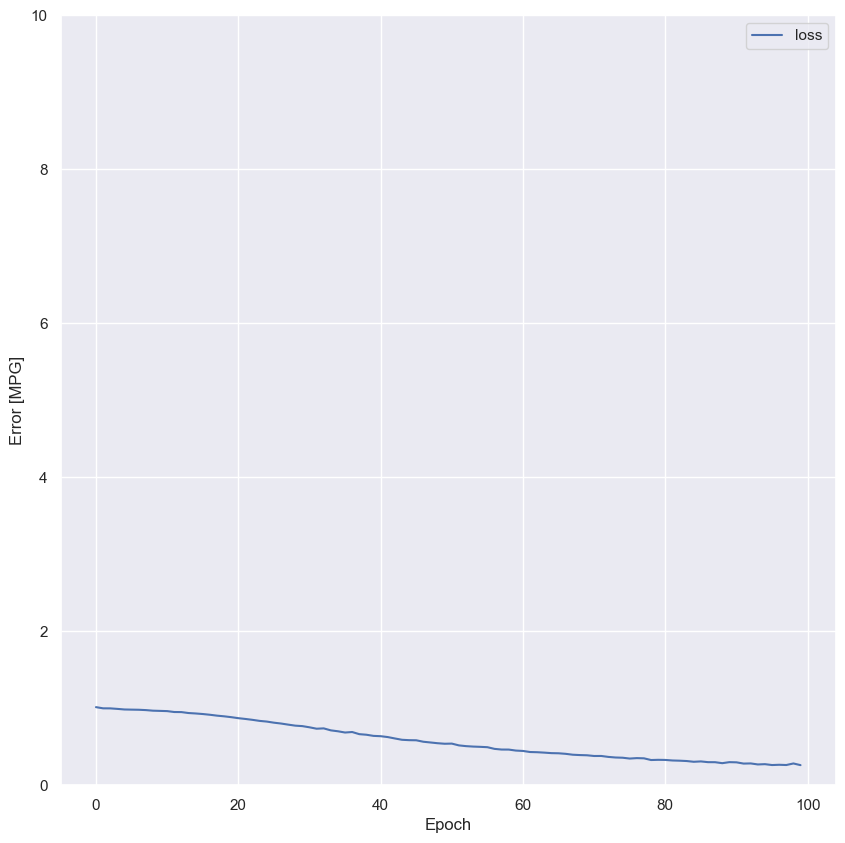

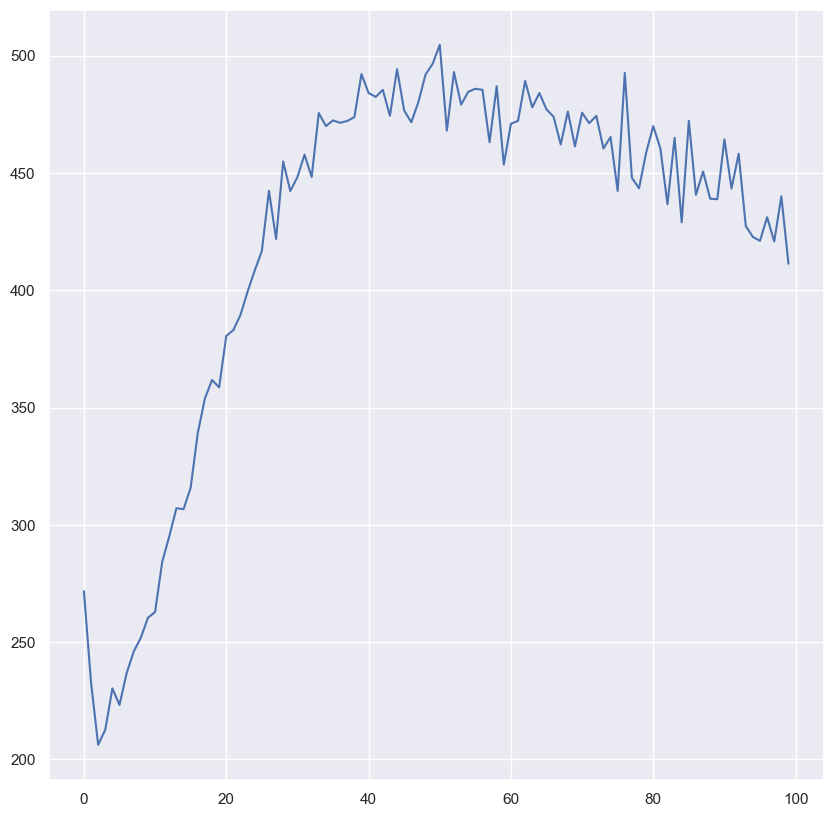

In [67]:
def build_model():
    model = keras.Sequential([
        layers.Dense(264, activation = "relu"),
        layers.Dense(264, activation = "relu"),
        layers.Dense(1)
    ])
    
    model.compile(loss = "mean_squared_error",
                  optimizer = tf.keras.optimizers.Adam(amsgrad = True), 
                  #optimizer = tfa.optimizers.RectifiedAdam(0.0001, amsgrad = True),
                  metrics = ["mse","mae","mape"])
    return model

def plot_loss(history, ylim):
  plt.plot(history.history['loss'], label='loss')
  #plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, ylim])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

dnn_model = build_model()
history = dnn_model.fit(np.array(features_train), np.array(target_train), verbose = 2, epochs = 200, shuffle = len(features_train))
results = dnn_model.evaluate(features_valid, target_valid, batch_size = len(features_valid))
print(results)
plot_loss(history, 10)
plt.show()
plt.plot(history.history["mse"])
plt.plot(history.history["mae"])
plt.show()
plt.plot(history.history["mape"])
plt.show()

In [68]:
#Добавляем пропущенные значения в таблицу и объединяем таблицы
data_train = features_train.join(target_train).reset_index(drop = True)
data_valid = features_valid.join(target_valid).reset_index(drop = True)
data2 = pd.concat([data_train] + [data_valid]).reset_index(drop = True)
data_nan2["Tenure"] = dnn_model.predict(features_nan).flatten()
display(data_nan2)
data = pd.concat([data2, data_nan2]).reset_index(drop = True)
display(data)
data.info()

CreditScore       Age    Tenure   Balance  EstimatedSalary  \
0      -0.580168  0.035995 -0.307316 -1.206852         0.732762   
1      -0.994205 -0.066254  0.325027  0.432434        -0.147342   
2      -0.640759 -0.270752  1.272171  1.108809        -0.226380   
3       0.066134  0.240493 -0.533901  0.783952         1.151091   
4       0.944702 -0.373000 -0.475535  0.963037        -0.260365   
..           ...       ...       ...       ...              ...   
904     0.964899  0.240493  0.912687  1.812117         0.695353   
905    -1.297159  0.751738 -1.274556  0.144270         0.322805   
906    -1.711197 -0.475249  0.545718  0.657611         0.250730   
907     0.106528 -0.270752  0.079360  0.756674        -0.041659   
908     1.449625 -1.088743 -0.104721  0.856582        -1.082392   

     NumOfProducts  HasCrCard  IsActiveMember  Exited  Geography_Germany  \
0                3          1               0       1                  0   
1                1          0               1       0                  1   
2                2          0               0       0                  1   
3                1          0               0       1                  1   
4                1          0               0       0                  1   
..             ...        ...             ...     ...                ...   
904              2          1               1       0                  1   
905              1          1               0       1                  0   
906              2          0               0       0                  0   
907              2          1               0       0                  0   
908              1          1               0       0                  0   

     Geography_Spain  Gender_Male  
0                  1            0  
1                  0            1  
2                  0            1  
3                  0            1  
4                  0            1  
..               ...          ...  
904                0            1  
905                0            0  
906                0            1  
907                0            1  
908                0            0  

[909 rows x 12 columns]

CreditScore       Age   Balance  EstimatedSalary  NumOfProducts  \
0       -1.037187  0.375163  0.937205        -1.635163              1   
1        0.297802 -0.096680 -1.233158        -0.590123              2   
2       -1.078582 -0.191049  0.307627         0.073185              2   
3       -1.130326 -1.040366 -1.233158         1.674643              2   
4       -0.478354  0.092057  0.420246        -1.069473              2   
...           ...       ...       ...              ...            ...   
9995     0.964899  0.240493  1.812117         0.695353              2   
9996    -1.297159  0.751738  0.144270         0.322805              1   
9997    -1.711197 -0.475249  0.657611         0.250730              2   
9998     0.106528 -0.270752  0.756674        -0.041659              2   
9999     1.449625 -1.088743  0.856582        -1.082392              1   

      HasCrCard  IsActiveMember  Exited  Geography_Germany  Geography_Spain  \
0             1               0       0                  1                0   
1             1               0       0                  0                0   
2             0               1       0                  1                0   
3             0               0       0                  0                1   
4             1               1       0                  0                0   
...         ...             ...     ...                ...              ...   
9995          1               1       0                  1                0   
9996          1               0       1                  0                0   
9997          0               0       0                  0                0   
9998          1               0       0                  0                0   
9999          1               0       0                  0                0   

      Gender_Male    Tenure  
0               0 -0.681448  
1               1 -0.681448  
2               1  1.384103  
3               1  1.039844  
4               1 -0.337189  
...           ...       ...  
9995            1  0.912687  
9996            0 -1.274556  
9997            1  0.545718  
9998            1  0.079360  
9999            0 -0.104721  

[10000 rows x 12 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  float64
 1   Age                10000 non-null  float64
 2   Balance            10000 non-null  float64
 3   EstimatedSalary    10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   Exited             10000 non-null  int64  
 8   Geography_Germany  10000 non-null  uint8  
 9   Geography_Spain    10000 non-null  uint8  
 10  Gender_Male        10000 non-null  uint8  
 11  Tenure             10000 non-null  float64
dtypes: float64(5), int64(4), uint8(3)
memory usage: 732.5 KB


# Вывод


Лучше всех оказалась нейронная сеть, поэтому мы взяли её, предсказали значения в столбце с пропусками("Tenure") и объеденили основную таблицу с таблицей пропущенных значений. 

In [69]:
#features_test = data_test.drop(["Exited"], axis = 1)
#target_test = data_test["Exited"]

#Получим тренировочную и валидационную выборки
features = data.drop(["Exited"], axis = 1)
target = data["Exited"]
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.3, random_state = 12345)
print(features_train.shape, features_valid.shape, target_train.shape, target_valid.shape)
display(features_train)
features_train.info()

(7000, 11) (3000, 11) (7000,) (3000,)


CreditScore       Age   Balance  EstimatedSalary  NumOfProducts  \
9716    -0.458986 -0.781996 -1.206852        -1.589671              2   
224      1.788023 -0.662891  0.637700         0.139930              1   
589     -2.755080  0.847005  0.307291         0.639522              1   
7507     0.597916  1.224480 -1.233158         0.155321              1   
1457     1.632791 -0.474154 -1.233158         0.237584              1   
...           ...       ...       ...              ...            ...   
4478    -0.033358 -1.323471  1.707222        -1.005372              2   
4094    -0.612888  0.469531  1.008701        -0.665118              1   
3492     0.318500 -1.134734 -1.233158        -1.179660              1   
2177    -0.374867 -0.568523  1.270845        -0.742408              2   
4578    -1.068233 -1.417840  1.280315         0.426557              1   

      HasCrCard  IsActiveMember  Geography_Germany  Geography_Spain  \
9716          0               1                  0                0   
224           1               0                  0                0   
589           0               0                  0                1   
7507          1               0                  0                1   
1457          0               0                  0                0   
...         ...             ...                ...              ...   
4478          1               1                  0                1   
4094          1               0                  0                1   
3492          1               0                  0                0   
2177          1               1                  1                0   
4578          1               1                  0                0   

      Gender_Male    Tenure  
9716            1 -0.665803  
224             1  1.039844  
589             0  1.039844  
7507            0  0.695586  
1457            0 -1.369965  
...           ...       ...  
4478            1  0.007069  
4094            0 -0.681448  
3492            1 -0.681448  
2177            1 -0.681448  
4578            1  1.039844  

[7000 rows x 11 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9716 to 4578
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        7000 non-null   float64
 1   Age                7000 non-null   float64
 2   Balance            7000 non-null   float64
 3   EstimatedSalary    7000 non-null   float64
 4   NumOfProducts      7000 non-null   int64  
 5   HasCrCard          7000 non-null   int64  
 6   IsActiveMember     7000 non-null   int64  
 7   Geography_Germany  7000 non-null   uint8  
 8   Geography_Spain    7000 non-null   uint8  
 9   Gender_Male        7000 non-null   uint8  
 10  Tenure             7000 non-null   float64
dtypes: float64(5), int64(3), uint8(3)
memory usage: 512.7 KB


# Исследование задачи

Для задачи классификации я взял несколько моделей в их числе: KNN, SVC, RFC, CatBoost, XGBoost. Посмотрим на модели без параметров на кросс-валидации, после чего отберем лучшие из них и подберем для них гиперпараметры.


ВАЖНО!!!

**Я оцениваю accuracy, вместо f1_score для отбора моделей, но после того как я отберу модели и подберу гиперпараметры, я оценю лучшие модели по f1_score**

In [70]:
!pip install xgboost
!pip install catboost
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
import catboost as cat
from sklearn.neighbors import KNeighborsClassifier as knn


knn_model = knn()
cat_model = cat.CatBoostClassifier(random_state = 12345, custom_loss = ["Accuracy", "F1"], eval_metric = "F1", 
                                  use_best_model = True, task_type = "GPU", verbose = True)
svc_model = SVC(random_state = 12345, kernel = "rbf")
rf_model = RandomForestClassifier(random_state = 12345)
xgb_model = xgb.XGBClassifier(random_state = 12345)


knn_model.fit(features_train, target_train)
cat_model.fit(features_train, target_train, eval_set = (features_valid, target_valid), early_stopping_rounds = 25, plot = False)
svc_model.fit(features_train, target_train)
rf_model.fit(features_train, target_train)
xgb_model.fit(features_train, target_train)

Learning rate set to 0.051245
0:	learn: 0.4818805	test: 0.4802867	best: 0.4802867 (0)	total: 4.56ms	remaining: 4.56s
1:	learn: 0.4927114	test: 0.4833333	best: 0.4833333 (1)	total: 7.52ms	remaining: 3.75s
2:	learn: 0.5068949	test: 0.5058005	best: 0.5058005 (2)	total: 10.5ms	remaining: 3.5s
3:	learn: 0.4927114	test: 0.4833333	best: 0.5058005 (2)	total: 12.9ms	remaining: 3.2s
4:	learn: 0.4983133	test: 0.4964871	best: 0.5058005 (2)	total: 15.8ms	remaining: 3.14s
5:	learn: 0.4961240	test: 0.4827586	best: 0.5058005 (2)	total: 18.8ms	remaining: 3.12s
6:	learn: 0.4973391	test: 0.4935065	best: 0.5058005 (2)	total: 21.9ms	remaining: 3.11s
7:	learn: 0.4941748	test: 0.4827586	best: 0.5058005 (2)	total: 24.6ms	remaining: 3.05s
8:	learn: 0.4941748	test: 0.4833333	best: 0.5058005 (2)	total: 27.6ms	remaining: 3.04s
9:	learn: 0.5007236	test: 0.4858491	best: 0.5058005 (2)	total: 30.7ms	remaining: 3.04s
10:	learn: 0.5128940	test: 0.5023256	best: 0.5058005 (2)	total: 33.6ms	remaining: 3.02s
11:	learn: 0.5

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:37:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1,
              random_state=12345, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

CatBoost предоставляет удобный параметр "use_best_model", с помощью которого можно отобрать лучшую модель по значению метрики, поэтому мы оценим CatBoost в отрыве от остальных, его результат: 0.8723

In [71]:
#result_cat = model_selection.cross_val_score(cat_model, features_valid, target_valid, scoring = "accuracy", cv = 25)

result_knn = model_selection.cross_val_score(knn_model, features_valid, target_valid, scoring = "f1", cv = 25)

result_svc = model_selection.cross_val_score(svc_model, features_valid, target_valid, scoring = "f1", cv = 25)

result_rf = model_selection.cross_val_score(rf_model, features_valid, target_valid, scoring = "f1", cv = 25)

result_xgb = model_selection.cross_val_score(xgb_model, features_valid, target_valid, scoring = "f1", cv = 25)



#print("CatBoost", result_cat.mean())


print("KNN", result_knn.mean())
print("SVC:", result_svc.mean())
print("RandomForestClassifier:", result_rf.mean())
print("XGBoost:", result_xgb.mean())

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:38:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
KNN 0.4448454570856121
SVC: 0.49780261228828093
RandomForestClassifier

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



По итогу кросс-валидации я оставил 3 модели для дальнейших испытаний: RFC, XGBoost, CatBoost

# Подбор гиперпараметров

С gridsearch и randomizedsearch были проблемы, поэтому пришлось обращаться к сторонним библиотекам. Но и здесь меня постигла проблема одинаковых чисел, кто бы мог подумать, что модели могут заражать других своими проблемами. На это я тоже не нашел внятного ответа, но это и неважно, потому что RFC слишком медленный, а небольшая разница в результате не стоит этого, а CatBoost вообще превосходит RFC.

In [72]:
!pip install optuna
import optuna
#rf_model2 = RandomForestClassifier()
#rf_model2.fit(features_train, target_train)
def objective(trial):
    
    n_estimators = int(trial.suggest_int("n_estimators", 100, 1000))
    
    max_depth = int(trial.suggest_int("max_depth", 1, 250))

    min_samples_split = int(trial.suggest_int("min_samples_split", 2, 250))

    min_samples_leaf = int(trial.suggest_int("min_samples_leaf", 1, 250))

    max_leaf_nodes = int(trial.suggest_int("max_leaf_nodes", 2, 250))

    #max_samples = int(trial.suggest_int("max_samples", 1, 250))

    min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 1, 250)
    
    classifier_obj = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split,
                                           min_samples_leaf = min_samples_leaf, max_leaf_nodes = max_leaf_nodes, #max_samples = max_samples,
                                           min_impurity_decrease = min_impurity_decrease, random_state = 12345)
    
    #score = model_selection.cross_val_score(classifier_obj, features_train, target_train, scoring = "accuracy", n_jobs = -1, cv = 3)
    
    classifier_obj.fit(features_train.to_numpy(), target_train.to_numpy())
    
    predict = classifier_obj.predict(features_valid.to_numpy())
    
    predict_labels = np.rint(predict)
    
    accuracy = accuracy_score(target_valid.to_numpy(), predict)#_labels)
    
    f1_scorie = f1_score(target_valid.to_numpy(), predict_labels)
    
    #accuracyi = score.mean()
    
    #return accuracy#, f1_scorie

    return f1_scorie

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 25)
print(study.best_trial)
#param_dist = {
#    "n_estimators" : n_estimators,
#    "max_depth" : max_depth,
#    "min_samples_split" : min_samples_split,
#    "min_samples_leaf" : min_samples_leaf,
#    "max_leaf_nodes" : max_leaf_nodes,
#    "max_samples" : max_samples,
#    "min_impurity_decrease" : min_impurity_decrease
#}

#rf = model_selection.RandomizedSearchCV(rf_model2, param_dist, n_iter = 250, n_jobs = -1, verbose = 0, random_state = 12345)
#rf.fit(features_train, target_train)

[I 2021-09-14 00:38:08,927] A new study created in memory with name: no-name-45d2c401-c5fd-45aa-9731-a235c169c831


[I 2021-09-14 00:38:10,082] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 578, 'max_depth': 222, 'min_samples_split': 147, 'min_samples_leaf': 250, 'max_leaf_nodes': 71, 'min_impurity_decrease': 21.891476484761597}. Best is trial 0 with value: 0.0.
[I 2021-09-14 00:38:10,535] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 226, 'max_depth': 159, 'min_samples_split': 222, 'min_samples_leaf': 19, 'max_leaf_nodes': 216, 'min_impurity_decrease': 131.59821163727202}. Best is trial 0 with value: 0.0.
[I 2021-09-14 00:38:12,230] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 858, 'max_depth': 159, 'min_samples_split': 154, 'min_samples_leaf': 166, 'max_leaf_nodes': 109, 'min_impurity_decrease': 92.6832665985492}. Best is trial 0 with value: 0.0.
[I 2021-09-14 00:38:14,197] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 995, 'max_depth': 151, 'min_samples_split': 168, 'min_samples_leaf': 218, 'max_leaf_nodes': 41, 'min

FrozenTrial(number=0, values=[0.0], datetime_start=datetime.datetime(2021, 9, 14, 0, 38, 8, 930676), datetime_complete=datetime.datetime(2021, 9, 14, 0, 38, 10, 82629), params={'n_estimators': 578, 'max_depth': 222, 'min_samples_split': 147, 'min_samples_leaf': 250, 'max_leaf_nodes': 71, 'min_impurity_decrease': 21.891476484761597}, distributions={'n_estimators': IntUniformDistribution(high=1000, low=100, step=1), 'max_depth': IntUniformDistribution(high=250, low=1, step=1), 'min_samples_split': IntUniformDistribution(high=250, low=2, step=1), 'min_samples_leaf': IntUniformDistribution(high=250, low=1, step=1), 'max_leaf_nodes': IntUniformDistribution(high=250, low=2, step=1), 'min_impurity_decrease': UniformDistribution(high=250.0, low=1.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


In [73]:
model_rfc = RandomForestClassifier(n_estimators = 647, max_depth = 68, min_samples_split = 141, min_samples_leaf = 93,
                                  max_leaf_nodes = 49, min_impurity_decrease = 149.75, random_state = 12345)
model_rfc.fit(features_train, target_train)
score = model_selection.cross_val_score(model_rfc, features_valid, target_valid, scoring = "accuracy", n_jobs = -1, cv = 10)
print(score.mean())

0.798


In [74]:
def objective(trial):
    dtrain = xgb.DMatrix(features_train, label = target_train)
    dvalid = xgb.DMatrix(features_valid, label = target_valid)
    param = {
        "n_estimators" : trial.suggest_int("n_estimators", 100, 5000), #= [int(x) for x in np.linspace(start = 100, stop = 1000, num = 1000)]
        
        "max_depth" : trial.suggest_int("max_depth", 1, 550), #= [int(x) for x in np.linspace(start = 1, stop = 250, num = 250)]

        "learning_rate" : trial.suggest_float("learning_rate", 0.05, 5.5), #= [x for x in np.linspace(start = 0.05, stop = 1.5, num = 0.05)]

        "min_child_weight" : trial.suggest_int("min_child_weight", 1, 550), #= [int(x) for x in np.linspace(start = 1, stop = 250, num = 250)]

        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.1, 1), #= [x for x in np.linspace(start = 0.1, stop = 25, num = 0.1)]

        "subsample" : trial.suggest_float("subsample", 0.1, 1), #= [x for x in np.linspace(start = 0.1, stop = 25, num = 0.1)]

        "booster" : trial.suggest_categorical("booster", ["gbtree", "dart"]),

        "gamma" : trial.suggest_float("gamma", 0.1, 55), #= [x for x in np.linspace(start = 0.1, stop = 25, num = 0.1)]

        #"sampling_method" : trial.suggest_categorical("sampling_method", ["uniform", "gradient_based"]),

        "three_method" : trial.suggest_categorical("three_method", ["auto", "exact", "approx", "hist", "gpu_hist"]),
        
        "max_delta_step" : trial.suggest_float("max_delta_step", 1, 10),
        
        "lambda" : trial.suggest_float("lambda", 0, 1),
        
        "alpha" : trial.suggest_float("alpha", 0, 1),
        
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        
        "max_bin" : trial.suggest_int("max_bin", 256, 1000)
    }
    
    model = xgb.train(param, dtrain)
    predictions = model.predict(dvalid)
    pred_labels = np.rint(predictions)
    accuracy = accuracy_score(target_valid, pred_labels)
    f1_scorie = f1_score(target_valid, pred_labels, average = "micro")
    
    #return accuracy, f1_scorie

    return f1_scorie

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 100, timeout = 600)
print(study.best_trial)

#param_dict = {
#    "n_estimators" : n_estimators,
#    "max_depth" : max_depth,
#    "learning_rate" : learning_rate,
#    "min_child_weight" : min_child_weight,
#    "colsample_bytree" : colsample_bytree,
#    "subsample" : subsample,
#    "booster" : booster,
#    "gamma" : gamma,
#    "sampling_method" : sampling_method,
#    "three_method" : three_method
#}

#xg = model_selection.RandomSearchCV(xgb_model, param_dict, n_iters = 200, n_jobs = -1, cv = 3, verbose = 1)
# xg.fit(features_train, target_train)

[I 2021-09-14 00:38:41,508] A new study created in memory with name: no-name-602d710f-ad53-4942-8a4d-3f37fec5de9d
[I 2021-09-14 00:38:41,531] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 3221, 'max_depth': 268, 'learning_rate': 4.225686105780224, 'min_child_weight': 130, 'colsample_bytree': 0.16479490262160248, 'subsample': 0.34019121927373497, 'booster': 'gbtree', 'gamma': 3.7677116563672177, 'three_method': 'gpu_hist', 'max_delta_step': 4.382817780507498, 'lambda': 0.5249307564620364, 'alpha': 0.6518227622171562, 'grow_policy': 'lossguide', 'max_bin': 549}. Best is trial 0 with value: 0.0.
[I 2021-09-14 00:38:41,554] Trial 1 finished with value: 0.202 and parameters: {'n_estimators': 443, 'max_depth': 546, 'learning_rate': 2.137934430013728, 'min_child_weight': 509, 'colsample_bytree': 0.9697433846003993, 'subsample': 0.31858044628248405, 'booster': 'dart', 'gamma': 32.73602685502307, 'three_method': 'gpu_hist', 'max_delta_step': 1.3406357408734149, 'lambda': 0.8

[00:38:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:41,727] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 645, 'max_depth': 428, 'learning_rate': 4.445336620840751, 'min_child_weight': 203, 'colsample_bytree': 0.4515107791535572, 'subsample': 0.5994655886537643, 'booster': 'dart', 'gamma': 33.833649401945245, 'three_method': 'exact', 'max_delta_step': 4.695862197331604, 'lambda': 0.2331258762628422, 'alpha': 0.9890435878411146, 'grow_policy': 'depthwise', 'max_bin': 371}. Best is trial 4 with value: 0.8370000000000001.
[I 2021-09-14 00:38:41,759] Trial 9 finished with value: 0.001666666666666667 and parameters: {'n_estimators': 1166, 'max_depth': 89, 'learning_rate': 3.2223890339681556, 'min_child_weight': 181, 'colsample_bytree': 0.9525500461224227, 'subsample': 0.7818804194281186, 'booster': 'dart', 'gamma': 10.06940460765119, 'three_method': 'auto', 'max_delta_step': 3.799324907771435, 'lambda': 0.9794529692661592, 'alpha': 0.7762244912083106, 'grow_policy': 'depthwise', 'max_bin': 368}. Best i

[00:38:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:41,927] Trial 13 finished with value: 0.83 and parameters: {'n_estimators': 1667, 'max_depth': 133, 'learning_rate': 1.3085037025492188, 'min_child_weight': 392, 'colsample_bytree': 0.7917852946968356, 'subsample': 0.7551161058558029, 'booster': 'dart', 'gamma': 0.41160906216066806, 'three_method': 'hist', 'max_delta_step': 8.15098030519594, 'lambda': 0.2989054316176578, 'alpha': 0.22991995868397117, 'grow_policy': 'lossguide', 'max_bin': 983}. Best is trial 12 with value: 0.8413333333333335.
[I 2021-09-14 00:38:41,980] Trial 14 finished with value: 0.822 and parameters: {'n_estimators': 4253, 'max_depth': 338, 'learning_rate': 1.225167695776451, 'min_child_weight': 74, 'colsample_bytree': 0.6085856044299215, 'subsample': 0.6364480393440812, 'booster': 'dart', 'gamma': 22.131718345139635, 'three_method': 'exact', 'max_delta_step': 7.648201770105772, 'lambda': 0.6936670931719271, 'alpha': 0.22548959693074214, 'grow_policy': 'lossguide', 'max_bin': 466}. Best is trial

[00:38:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:42,161] Trial 19 finished with value: 0.838 and parameters: {'n_estimators': 4295, 'max_depth': 143, 'learning_rate': 1.697112432499982, 'min_child_weight': 347, 'colsample_bytree': 0.8357627559931424, 'subsample': 0.8475071504735161, 'booster': 'dart', 'gamma': 5.422159839641164, 'three_method': 'auto', 'max_delta_step': 6.597484746310426, 'lambda': 0.8366507852029369, 'alpha': 0.11900933021378679, 'grow_policy': 'lossguide', 'max_bin': 700}. Best is trial 12 with value: 0.8413333333333335.
[I 2021-09-14 00:38:42,201] Trial 20 finished with value: 0.842 and parameters: {'n_estimators': 4372, 'max_depth': 112, 'learning_rate': 1.7376938821738002, 'min_child_weight': 448, 'colsample_bytree': 0.6740596333950621, 'subsample': 0.8747466983163179, 'booster': 'dart', 'gamma': 25.95632882080602, 'three_method': 'auto', 'max_delta_step': 9.915157193438404, 'lambda': 0.8203005335197957, 'alpha': 0.34987406958973655, 'grow_policy': 'lossguide', 'max_bin': 700}. Best is trial 

[00:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:42,388] Trial 25 finished with value: 0.0 and parameters: {'n_estimators': 3899, 'max_depth': 89, 'learning_rate': 3.7714863490544204, 'min_child_weight': 450, 'colsample_bytree': 0.6841227790617362, 'subsample': 0.9061704676587495, 'booster': 'dart', 'gamma': 24.52203366932359, 'three_method': 'auto', 'max_delta_step': 9.926264375008126, 'lambda': 0.7585625758161626, 'alpha': 0.2826657792333413, 'grow_policy': 'lossguide', 'max_bin': 991}. Best is trial 20 with value: 0.842.
[I 2021-09-14 00:38:42,426] Trial 26 finished with value: 0.8326666666666668 and parameters: {'n_estimators': 4954, 'max_depth': 67, 'learning_rate': 0.57670747714861, 'min_child_weight': 491, 'colsample_bytree': 0.462242003352093, 'subsample': 0.8691440463206846, 'booster': 'dart', 'gamma': 30.51176882620437, 'three_method': 'auto', 'max_delta_step': 9.109534482518185, 'lambda': 0.887769892001997, 'alpha': 0.5080575788419711, 'grow_policy': 'lossguide', 'max_bin': 769}. Best is trial 20 with v

[00:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:42,656] Trial 32 finished with value: 0.079 and parameters: {'n_estimators': 4664, 'max_depth': 104, 'learning_rate': 2.1210357836335216, 'min_child_weight': 350, 'colsample_bytree': 0.9932892027241969, 'subsample': 0.9290872798307254, 'booster': 'dart', 'gamma': 15.593852216974387, 'three_method': 'auto', 'max_delta_step': 9.671350692994793, 'lambda': 0.8156607663854226, 'alpha': 0.14155825343630463, 'grow_policy': 'lossguide', 'max_bin': 794}. Best is trial 20 with value: 0.842.
[I 2021-09-14 00:38:42,694] Trial 33 finished with value: 0.0 and parameters: {'n_estimators': 4197, 'max_depth': 194, 'learning_rate': 2.7001884391809474, 'min_child_weight': 438, 'colsample_bytree': 0.8466843870513929, 'subsample': 0.9924295863909568, 'booster': 'dart', 'gamma': 36.82971964393825, 'three_method': 'auto', 'max_delta_step': 2.2577687533399327, 'lambda': 0.8499124519510226, 'alpha': 0.19962998119776987, 'grow_policy': 'lossguide', 'max_bin': 747}. Best is trial 20 with valu

[00:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:42,851] Trial 37 finished with value: 0.798 and parameters: {'n_estimators': 4692, 'max_depth': 539, 'learning_rate': 0.40126713570182804, 'min_child_weight': 504, 'colsample_bytree': 0.5179457843057704, 'subsample': 0.25498129530614366, 'booster': 'dart', 'gamma': 23.947184089280515, 'three_method': 'hist', 'max_delta_step': 9.99562954684087, 'lambda': 0.6158546388028913, 'alpha': 0.6303646405248585, 'grow_policy': 'depthwise', 'max_bin': 530}. Best is trial 20 with value: 0.842.
[I 2021-09-14 00:38:42,904] Trial 38 finished with value: 0.8516666666666667 and parameters: {'n_estimators': 3844, 'max_depth': 267, 'learning_rate': 1.1621323222332225, 'min_child_weight': 146, 'colsample_bytree': 0.7096403245202285, 'subsample': 0.9422267911573082, 'booster': 'dart', 'gamma': 11.711749136707306, 'three_method': 'hist', 'max_delta_step': 9.256698667071326, 'lambda': 0.7238187748381755, 'alpha': 0.7170573983899798, 'grow_policy': 'lossguide', 'max_bin': 572}. Best is tria

[00:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:43,065] Trial 41 finished with value: 0.8506666666666667 and parameters: {'n_estimators': 3869, 'max_depth': 373, 'learning_rate': 1.127153367727685, 'min_child_weight': 133, 'colsample_bytree': 0.7808401124999057, 'subsample': 0.9273924036721963, 'booster': 'dart', 'gamma': 12.428254404879867, 'three_method': 'hist', 'max_delta_step': 8.672259899844747, 'lambda': 0.724312381050018, 'alpha': 0.8671582283441447, 'grow_policy': 'depthwise', 'max_bin': 587}. Best is trial 40 with value: 0.861.
[I 2021-09-14 00:38:43,120] Trial 42 finished with value: 0.8543333333333333 and parameters: {'n_estimators': 3801, 'max_depth': 384, 'learning_rate': 0.6942614764103786, 'min_child_weight': 136, 'colsample_bytree': 0.7727903278955859, 'subsample': 0.9426869593218531, 'booster': 'dart', 'gamma': 12.67435295375035, 'three_method': 'hist', 'max_delta_step': 8.635054350011355, 'lambda': 0.7093494899229741, 'alpha': 0.8692844429091833, 'grow_policy': 'depthwise', 'max_bin': 458}. Bes

[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:43,274] Trial 45 finished with value: 0.859 and parameters: {'n_estimators': 3404, 'max_depth': 394, 'learning_rate': 0.37942434004222336, 'min_child_weight': 98, 'colsample_bytree': 0.881191709670599, 'subsample': 0.8055046940051552, 'booster': 'gbtree', 'gamma': 8.795966941612873, 'three_method': 'hist', 'max_delta_step': 5.804217023818645, 'lambda': 0.650943831326524, 'alpha': 0.8964240157431899, 'grow_policy': 'depthwise', 'max_bin': 399}. Best is trial 40 with value: 0.861.
[I 2021-09-14 00:38:43,327] Trial 46 finished with value: 0.8603333333333333 and parameters: {'n_estimators': 2454, 'max_depth': 483, 'learning_rate': 0.35135563528994646, 'min_child_weight': 84, 'colsample_bytree': 0.9494055911528327, 'subsample': 0.807458401685774, 'booster': 'gbtree', 'gamma': 8.10823811105718, 'three_method': 'hist', 'max_delta_step': 5.55166683145849, 'lambda': 0.6336946795796728, 'alpha': 0.9089366725105836, 'grow_policy': 'depthwise', 'max_bin': 387}. Best is trial 40

[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:43,470] Trial 49 finished with value: 0.8616666666666667 and parameters: {'n_estimators': 2227, 'max_depth': 504, 'learning_rate': 0.08114207976068433, 'min_child_weight': 70, 'colsample_bytree': 0.945029243613832, 'subsample': 0.5335120881470886, 'booster': 'gbtree', 'gamma': 4.030065809965768, 'three_method': 'hist', 'max_delta_step': 5.332025570516227, 'lambda': 0.5383822389099262, 'alpha': 0.9735696379758338, 'grow_policy': 'depthwise', 'max_bin': 342}. Best is trial 48 with value: 0.8633333333333333.
[I 2021-09-14 00:38:43,543] Trial 50 finished with value: 0.8626666666666667 and parameters: {'n_estimators': 2130, 'max_depth': 502, 'learning_rate': 0.09171887671114776, 'min_child_weight': 9, 'colsample_bytree': 0.9358289545240489, 'subsample': 0.5421063997184807, 'booster': 'gbtree', 'gamma': 2.982407101278123, 'three_method': 'approx', 'max_delta_step': 4.713970151914346, 'lambda': 0.5482926232854135, 'alpha': 0.9778905102680888, 'grow_policy': 'depthwise', 'm

[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:43,679] Trial 52 finished with value: 0.868 and parameters: {'n_estimators': 2110, 'max_depth': 499, 'learning_rate': 0.056677904268688156, 'min_child_weight': 10, 'colsample_bytree': 0.984113424369174, 'subsample': 0.5354108501243315, 'booster': 'gbtree', 'gamma': 1.4386881487606866, 'three_method': 'approx', 'max_delta_step': 4.836489680673068, 'lambda': 0.5594802828814728, 'alpha': 0.9982953444193098, 'grow_policy': 'depthwise', 'max_bin': 322}. Best is trial 52 with value: 0.868.
[I 2021-09-14 00:38:43,740] Trial 53 finished with value: 0.8633333333333333 and parameters: {'n_estimators': 2098, 'max_depth': 505, 'learning_rate': 0.07948091241288215, 'min_child_weight': 24, 'colsample_bytree': 0.9946934014624401, 'subsample': 0.5406326028565518, 'booster': 'gbtree', 'gamma': 2.840546219817152, 'three_method': 'approx', 'max_delta_step': 4.8051666994148725, 'lambda': 0.5455442405517195, 'alpha': 0.9958095775047104, 'grow_policy': 'depthwise', 'max_bin': 324}. Best 

[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:43,893] Trial 55 finished with value: 0.865 and parameters: {'n_estimators': 1919, 'max_depth': 549, 'learning_rate': 0.06060845543482937, 'min_child_weight': 7, 'colsample_bytree': 0.9910774212070916, 'subsample': 0.4710377152406323, 'booster': 'gbtree', 'gamma': 2.447324381713974, 'three_method': 'approx', 'max_delta_step': 4.263463330448936, 'lambda': 0.4682996926517184, 'alpha': 0.9897451154442183, 'grow_policy': 'depthwise', 'max_bin': 304}. Best is trial 52 with value: 0.868.
[I 2021-09-14 00:38:43,949] Trial 56 finished with value: 0.867 and parameters: {'n_estimators': 1875, 'max_depth': 541, 'learning_rate': 0.5775127567631473, 'min_child_weight': 36, 'colsample_bytree': 0.9998901676222504, 'subsample': 0.4663115624331348, 'booster': 'gbtree', 'gamma': 2.3032546476072726, 'three_method': 'approx', 'max_delta_step': 4.311982939082522, 'lambda': 0.4662481664133594, 'alpha': 0.812924430872667, 'grow_policy': 'depthwise', 'max_bin': 305}. Best is trial 52 with 

[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:44,207] Trial 60 finished with value: 0.861 and parameters: {'n_estimators': 1547, 'max_depth': 528, 'learning_rate': 0.9068889085638462, 'min_child_weight': 2, 'colsample_bytree': 0.9094445922772662, 'subsample': 0.4581774973437857, 'booster': 'gbtree', 'gamma': 5.787249066553283, 'three_method': 'approx', 'max_delta_step': 3.221818851863058, 'lambda': 0.3824785934342219, 'alpha': 0.8249096969189617, 'grow_policy': 'depthwise', 'max_bin': 297}. Best is trial 52 with value: 0.868.
[I 2021-09-14 00:38:44,267] Trial 61 finished with value: 0.869 and parameters: {'n_estimators': 1880, 'max_depth': 458, 'learning_rate': 0.21661668099052173, 'min_child_weight': 37, 'colsample_bytree': 0.9694247791894306, 'subsample': 0.6137479514590176, 'booster': 'gbtree', 'gamma': 1.8030397381702161, 'three_method': 'approx', 'max_delta_step': 4.242917357777092, 'lambda': 0.4368239274386866, 'alpha': 0.9570971859917496, 'grow_policy': 'depthwise', 'max_bin': 353}. Best is trial 61 with

[00:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:44,327] Trial 62 finished with value: 0.869 and parameters: {'n_estimators': 1881, 'max_depth': 455, 'learning_rate': 0.24339420979715984, 'min_child_weight': 42, 'colsample_bytree': 0.9131629579644441, 'subsample': 0.5890486493956656, 'booster': 'gbtree', 'gamma': 0.8610624609148726, 'three_method': 'approx', 'max_delta_step': 4.006929675800807, 'lambda': 0.34818362802917724, 'alpha': 0.951756676818404, 'grow_policy': 'depthwise', 'max_bin': 415}. Best is trial 61 with value: 0.869.
[I 2021-09-14 00:38:44,383] Trial 63 finished with value: 0.8676666666666667 and parameters: {'n_estimators': 1171, 'max_depth': 461, 'learning_rate': 0.245264489026235, 'min_child_weight': 49, 'colsample_bytree': 0.9675854413340153, 'subsample': 0.5950375418370214, 'booster': 'gbtree', 'gamma': 0.9047306853125276, 'three_method': 'approx', 'max_delta_step': 4.3313544054898285, 'lambda': 0.2337381468903197, 'alpha': 0.9446328709050495, 'grow_policy': 'depthwise', 'max_bin': 414}. Best i

[00:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:44,567] Trial 67 finished with value: 0.822 and parameters: {'n_estimators': 361, 'max_depth': 417, 'learning_rate': 0.5458363360783713, 'min_child_weight': 60, 'colsample_bytree': 0.8159113725529292, 'subsample': 0.6740666231370274, 'booster': 'gbtree', 'gamma': 52.0970395276255, 'three_method': 'approx', 'max_delta_step': 3.887863751196787, 'lambda': 0.2508509565020553, 'alpha': 0.7885090449685989, 'grow_policy': 'depthwise', 'max_bin': 437}. Best is trial 61 with value: 0.869.
[I 2021-09-14 00:38:44,615] Trial 68 finished with value: 0.8623333333333333 and parameters: {'n_estimators': 531, 'max_depth': 523, 'learning_rate': 0.24824503053760233, 'min_child_weight': 109, 'colsample_bytree': 0.9093093759880195, 'subsample': 0.5760532118963804, 'booster': 'gbtree', 'gamma': 6.142758858373735, 'three_method': 'approx', 'max_delta_step': 1.9664006422607605, 'lambda': 0.36607301893029853, 'alpha': 0.9479448561858866, 'grow_policy': 'depthwise', 'max_bin': 422}. Best is 

[00:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:44,776] Trial 71 finished with value: 0.863 and parameters: {'n_estimators': 1970, 'max_depth': 523, 'learning_rate': 0.2763887748825315, 'min_child_weight': 47, 'colsample_bytree': 0.9658745534336758, 'subsample': 0.5001239578538592, 'booster': 'gbtree', 'gamma': 4.079165171062816, 'three_method': 'approx', 'max_delta_step': 4.269717858649979, 'lambda': 0.4639715444293901, 'alpha': 0.752248488376712, 'grow_policy': 'depthwise', 'max_bin': 314}. Best is trial 61 with value: 0.869.
[I 2021-09-14 00:38:44,848] Trial 72 finished with value: 0.866 and parameters: {'n_estimators': 1474, 'max_depth': 464, 'learning_rate': 0.2190164674184905, 'min_child_weight': 19, 'colsample_bytree': 0.9172799798033775, 'subsample': 0.6287197533502464, 'booster': 'gbtree', 'gamma': 2.222855838264956, 'three_method': 'approx', 'max_delta_step': 3.014008349616925, 'lambda': 0.10358460464059643, 'alpha': 0.9195645747512776, 'grow_policy': 'depthwise', 'max_bin': 417}. Best is trial 61 with 

[00:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:45,046] Trial 75 finished with value: 0.861 and parameters: {'n_estimators': 1690, 'max_depth': 469, 'learning_rate': 0.5092534180847976, 'min_child_weight': 27, 'colsample_bytree': 0.9259684219322211, 'subsample': 0.6856290034903983, 'booster': 'gbtree', 'gamma': 6.530478656613867, 'three_method': 'approx', 'max_delta_step': 1.538438154957627, 'lambda': 0.0823947451485087, 'alpha': 0.8427970720020285, 'grow_policy': 'depthwise', 'max_bin': 282}. Best is trial 61 with value: 0.869.
[I 2021-09-14 00:38:45,115] Trial 76 finished with value: 0.8663333333333333 and parameters: {'n_estimators': 1511, 'max_depth': 308, 'learning_rate': 0.9788937156814751, 'min_child_weight': 21, 'colsample_bytree': 0.8149946784287414, 'subsample': 0.6141747665456952, 'booster': 'gbtree', 'gamma': 4.419662244264467, 'three_method': 'approx', 'max_delta_step': 2.6017322507224834, 'lambda': 0.1376440286918347, 'alpha': 0.8930951024908946, 'grow_policy': 'depthwise', 'max_bin': 356}. Best is 

[00:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-14 00:38:45,303] Trial 78 finished with value: 0.8613333333333333 and parameters: {'n_estimators': 1670, 'max_depth': 355, 'learning_rate': 1.0142004043238608, 'min_child_weight': 63, 'colsample_bytree': 0.8179078129531352, 'subsample': 0.606354815502277, 'booster': 'gbtree', 'gamma': 6.237954172048966, 'three_method': 'approx', 'max_delta_step': 3.524850436425486, 'lambda': 0.20732510726264688, 'alpha': 0.7595844318678865, 'grow_policy': 'depthwise', 'max_bin': 384}. Best is trial 61 with value: 0.869.
[I 2021-09-14 00:38:45,369] Trial 79 finished with value: 0.8633333333333333 and parameters: {'n_estimators': 1145, 'max_depth': 408, 'learning_rate': 0.7838869814040732, 'min_child_weight': 33, 'colsample_bytree': 0.967492697281331, 'subsample': 0.6566631809495203, 'booster': 'gbtree', 'gamma': 3.7612938492280006, 'three_method': 'approx', 'max_delta_step': 6.209463021050317, 'lambda': 0.01328257640318875, 'alpha': 0.9645824795982317, 'grow_policy': 'depthwise', 'max_bin': 3

[00:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:45,516] Trial 82 finished with value: 0.8683333333333333 and parameters: {'n_estimators': 1795, 'max_depth': 449, 'learning_rate': 0.4674128238687375, 'min_child_weight': 49, 'colsample_bytree': 0.8882920785672382, 'subsample': 0.6332637536829895, 'booster': 'gbtree', 'gamma': 2.0894061606566505, 'three_method': 'approx', 'max_delta_step': 3.794126586021287, 'lambda': 0.042102526788716, 'alpha': 0.9229852227127928, 'grow_policy': 'depthwise', 'max_bin': 479}. Best is trial 61 with value: 0.869.
[I 2021-09-14 00:38:45,571] Trial 83 finished with value: 0.8576666666666667 and parameters: {'n_estimators': 2685, 'max_depth': 437, 'learning_rate': 0.49007179143386514, 'min_child_weight': 51, 'colsample_bytree': 0.8843756836381415, 'subsample': 0.5653851882091259, 'booster': 'gbtree', 'gamma': 6.831676047936595, 'three_method': 'approx', 'max_delta_step': 4.071116698063651, 'lambda': 0.03546431561085135, 'alpha': 0.806670011940928, 'grow_policy': 'depthwise', 'max_bin': 4

[00:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:45,688] Trial 85 finished with value: 0.853 and parameters: {'n_estimators': 1590, 'max_depth': 442, 'learning_rate': 0.6585096376348345, 'min_child_weight': 47, 'colsample_bytree': 0.9524983733179387, 'subsample': 0.6098108163386445, 'booster': 'gbtree', 'gamma': 9.24258579370021, 'three_method': 'exact', 'max_delta_step': 4.523491371544358, 'lambda': 0.28068322758492614, 'alpha': 0.9294033345397368, 'grow_policy': 'depthwise', 'max_bin': 388}. Best is trial 61 with value: 0.869.
[I 2021-09-14 00:38:45,746] Trial 86 finished with value: 0.841 and parameters: {'n_estimators': 1776, 'max_depth': 514, 'learning_rate': 0.4010473670253153, 'min_child_weight': 30, 'colsample_bytree': 0.23536871118251046, 'subsample': 0.6465906697435923, 'booster': 'gbtree', 'gamma': 5.468416491759422, 'three_method': 'approx', 'max_delta_step': 3.3088181032523423, 'lambda': 0.05588145133647032, 'alpha': 0.9659369824643176, 'grow_policy': 'depthwise', 'max_bin': 323}. Best is trial 61 wit

[00:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:45,926] Trial 89 finished with value: 0.835 and parameters: {'n_estimators': 2443, 'max_depth': 452, 'learning_rate': 0.18231776721035148, 'min_child_weight': 222, 'colsample_bytree': 0.7981120859023015, 'subsample': 0.4154799988052144, 'booster': 'gbtree', 'gamma': 2.1251319572982337, 'three_method': 'approx', 'max_delta_step': 2.100451381108753, 'lambda': 0.3529789791933869, 'alpha': 0.550662845549885, 'grow_policy': 'depthwise', 'max_bin': 359}. Best is trial 61 with value: 0.869.
[I 2021-09-14 00:38:45,983] Trial 90 finished with value: 0.8623333333333333 and parameters: {'n_estimators': 2066, 'max_depth': 295, 'learning_rate': 0.3549627427273795, 'min_child_weight': 55, 'colsample_bytree': 0.8628635410981588, 'subsample': 0.6843197282126241, 'booster': 'gbtree', 'gamma': 3.5709396892641445, 'three_method': 'approx', 'max_delta_step': 2.756126574926868, 'lambda': 0.5154004206790463, 'alpha': 0.8576933547572856, 'grow_policy': 'depthwise', 'max_bin': 466}. Best i

[00:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:46,206] Trial 92 finished with value: 0.8556666666666666 and parameters: {'n_estimators': 1363, 'max_depth': 236, 'learning_rate': 0.6129778982432947, 'min_child_weight': 1, 'colsample_bytree': 0.9403660393407773, 'subsample': 0.5669212029118224, 'booster': 'gbtree', 'gamma': 1.8238902942850008, 'three_method': 'approx', 'max_delta_step': 4.642279250966921, 'lambda': 0.05908081181447447, 'alpha': 0.8837924766821946, 'grow_policy': 'depthwise', 'max_bin': 394}. Best is trial 61 with value: 0.869.
[I 2021-09-14 00:38:46,267] Trial 93 finished with value: 0.859 and parameters: {'n_estimators': 1859, 'max_depth': 494, 'learning_rate': 0.4747054157521571, 'min_child_weight': 39, 'colsample_bytree': 0.9623299083448426, 'subsample': 0.6308865760368212, 'booster': 'gbtree', 'gamma': 7.266149195135091, 'three_method': 'approx', 'max_delta_step': 4.260582236543021, 'lambda': 0.18755580972598085, 'alpha': 0.932590630039143, 'grow_policy': 'depthwise', 'max_bin': 380}. Best is 

[00:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

[I 2021-09-14 00:38:46,452] Trial 96 finished with value: 0.8626666666666667 and parameters: {'n_estimators': 1678, 'max_depth': 443, 'learning_rate': 0.33092737588821103, 'min_child_weight': 29, 'colsample_bytree': 0.9013408589919921, 'subsample': 0.602900995317991, 'booster': 'gbtree', 'gamma': 3.4939198497557866, 'three_method': 'approx', 'max_delta_step': 3.5915561751616893, 'lambda': 0.3213230538747215, 'alpha': 0.8962990103637816, 'grow_policy': 'depthwise', 'max_bin': 548}. Best is trial 61 with value: 0.869.
[I 2021-09-14 00:38:46,500] Trial 97 finished with value: 0.8546666666666667 and parameters: {'n_estimators': 1990, 'max_depth': 475, 'learning_rate': 1.5435901106431817, 'min_child_weight': 75, 'colsample_bytree': 0.8765509251757247, 'subsample': 0.44250811621239633, 'booster': 'gbtree', 'gamma': 5.018127784939944, 'three_method': 'gpu_hist', 'max_delta_step': 3.87031786159611, 'lambda': 0.4826782556445522, 'alpha': 0.9292527040562187, 'grow_policy': 'depthwise', 'max_bin'

[00:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "three_method" } might not be used.

  This may not 

Прирост 1,5 процента точности! Сохраним модель с лучшими параметрами в переменной xgb_model2.

In [75]:
xgb_model2 = xgb.XGBClassifier(n_estimators = 836, max_depth = 340, learning_rate = 0.411, min_child_weight = 139, 
                              colsample_bytree = 0.9317, subsample = 0.926, booster = "gbtree", gamma = 0.1034, 
                              three_method = "hist", max_delta_step = 1.711, alpha = 0.0031, 
                              grow_policy = "lossguide", max_bin = 317)

xgb_model2.fit(features_train, target_train)

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=0.0031, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9317,
              gamma=0.1034, gpu_id=-1, grow_policy='lossguide',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.411, max_bin=317, max_delta_step=1.711,
              max_depth=340, min_child_weight=139, missing=nan,
              monotone_constraints='()', n_estimators=836, n_jobs=6,
              num_parallel_tree=1, random_state=0, reg_alpha=0.00310000009,
              reg_lambda=1, scale_pos_weight=1, subsample=0.926,
              three_method='hist', tree_method='exact', validate_parameters=1,
              verbosity=None)

У CatBoost есть встроенная перекрестная проверка, воспользуемся ей. 

In [76]:
cat_model2 = cat.CatBoostClassifier(random_state = 12345, custom_loss = ["Accuracy", "F1"], eval_metric = "F1")
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 1000)]
learning_rate = [x for x in np.arange(0.1, 1, 0.1)]
depth = [int(x) for x in np.linspace(start = 1, stop = 16, num = 16)]
grow_policy = ["SymmetricTree", "Depthwise", "Lossguide"]
min_child_samples = [int(x) for x in np.linspace(start = 1, stop = 250, num = 250)]
leb = ["AnyImprovement", "Armijo"]
score_function = ["Cosine", "L2"]
l2_leaf_reg = [x for x in np.linspace(start = 1, stop = 250, num = 245)]
border_count = [int(x) for x in np.linspace(start = 1, stop = 255, num = 255)]
ctr_target_border_count = [int(x) for x in np.linspace(start = 1, stop = 255, num = 255)]
loss_function = ["LogLoss", "CrossEntropy"]
subsample = [x for x in np.arange(0.1, 1, 0.1)]
lei = [int(x) for x in np.linspace(start = 1, stop = 200, num = 200)]
bootstrap_type = ["Bayesian", "Bernoulli", "MVS", "Poisson"]
bag_temp = [x for x in np.linspace(start = 1, stop = 200.5, num = 195)]
sampling_frequency = ["PerTree", "PerTreeLevel"]
sampling_unit = ["Object", "Group"]
max_leaves = [int(x) for x in np.linspace(start = 1, stop = 64, num = 64)]
lem = ["Newton", "Gradient", "Exact"]
boosting_type = ["Ordered", "Plain"]
boost_to_average = [True, False]
langevin = [True, False]
grid = {
    "n_estimators" : n_estimators,
    "learning_rate" : learning_rate,
    "depth" : depth,
    "grow_policy" : grow_policy,
    "min_child_samples" : min_child_samples,
    "leaf_estimation_backtracking" : leb,
    #"score_function" : score_function,
    #"l2_leaf_reg" : l2_leaf_reg,
    #"border_count" : border_count,
    #"ctr_target_border_count" : ctr_target_border_count,
    #"subsample" : subsample,
    #"leaf_estimation_iterations" : lei,
    #"bootstrap_type" : bootstrap_type,
    #"bagging_temperature" : bag_temp,
    #"sampling_frequency" : sampling_frequency,
    #"sampling_unit" : sampling_unit,
    #"max_leaves" : max_leaves,
    #"leaf_estimation_method" : lem,
    #"boosting_type" : boosting_type,
    #"boost_from_average" : boost_to_average,
    #"langevin" : langevin,
    #"loss_function" : loss_function
}

grid_search = cat_model2.randomized_search(grid, features_train, target_train, n_iter = 50, cv = 3, plot = True, verbose = True)
#cat_model3 = cat.CatBoostClassifier(iterations = 500, depth = 6, learning_rate = 0.1, custom_loss = ["Accuracy", "F1"], 
                                   #eval_metric = "Accuracy", verbose = True, use_best_model = True, task_type = "GPU")
#cat_model3.fit(features_train, target_train, eval_set = (features_valid, target_valid), early_stopping_rounds = 50, plot = False)
#score = model_selection.cross_val_score(cat_model3, features_valid, target_valid, scoring = "accuracy", cv = 10)
#print(score.mean())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.37ms	remaining: 320ms
1:	learn: 0.2247532	test: 0.2832370	best: 0.2832370 (1)	total: 5.08ms	remaining: 340ms
2:	learn: 0.2247532	test: 0.2832370	best: 0.2832370 (1)	total: 7.6ms	remaining: 337ms
3:	learn: 0.4638404	test: 0.4952830	best: 0.4952830 (3)	total: 10.2ms	remaining: 338ms
4:	learn: 0.5092379	test: 0.5466667	best: 0.5466667 (4)	total: 12.7ms	remaining: 332ms
5:	learn: 0.4994152	test: 0.5282167	best: 0.5466667 (4)	total: 15.3ms	remaining: 331ms
6:	learn: 0.5037901	test: 0.5315315	best: 0.5466667 (4)	total: 18.1ms	remaining: 334ms
7:	learn: 0.5285795	test: 0.5577342	best: 0.5577342 (7)	total: 21ms	remaining: 336ms
8:	learn: 0.5231826	test: 0.5575221	best: 0.5577342 (7)	total: 23.4ms	remaining: 331ms
9:	learn: 0.5382883	test: 0.5683297	best: 0.5683297 (9)	total: 25.9ms	remaining: 327ms
10:	learn: 0.5409652	test: 0.5720430	best: 0.5720430 (10)	total: 28.7ms	remaining: 327ms
11:	learn: 0.5377678	test: 0.5689655	best: 0

Понабрал так много гиперпараметров, что CatBoost отказывался их перебирать) Некоторые по типу "subsample" отрицательно влияли на результат, некоторые нейтрально, но по итогу лучше всего для нашей задачи те, которые я не закомментировал в словаре.
Получили точность чуть больше 90 процентов, улучшили дефолтный результат. Дополнительно выведем параметры лучшей модели и сведем в таблицу все результаты(следующая ячейка).

In [77]:
#Сводим в таблицу полученные результаты, сортируя по точности модели и удаляем ненужные столбцы
print(grid_search["params"])
xg_df = pd.DataFrame(grid_search["cv_results"]).sort_values("test-Accuracy-mean", ascending = False).reset_index(drop = True)
#xg_df = xg_df.drop([
#    "mean_fit_time",
#    "std_fit_time",
#    "mean_score_time",
#    "std_score_time",
#    "params",
#    "split0_test_score",
#    "split1_test_score",
#    "split2_test_score",
#    "std_test_score"],
#    axis = 1)
xg_df.head(10)

{'min_data_in_leaf': 7, 'depth': 5, 'iterations': 334, 'learning_rate': 0.2, 'grow_policy': 'Lossguide', 'leaf_estimation_backtracking': 'AnyImprovement'}
0:	learn: 0.5243790	test: 0.5026853	best: 0.5026853 (0)	total: 13.2ms	remaining: 5.65s
1:	learn: 0.5059172	test: 0.4964706	best: 0.5026853 (0)	total: 24.3ms	remaining: 5.2s
2:	learn: 0.5300286	test: 0.5194508	best: 0.5194508 (2)	total: 37.8ms	remaining: 5.38s
3:	learn: 0.5766165	test: 0.5696068	best: 0.5696068 (3)	total: 49.2ms	remaining: 5.24s
4:	learn: 0.5596670	test: 0.5361513	best: 0.5696068 (3)	total: 61.7ms	remaining: 5.24s
5:	learn: 0.5777166	test: 0.5516484	best: 0.5696068 (3)	total: 73.6ms	remaining: 5.2s
6:	learn: 0.5903124	test: 0.5621622	best: 0.5696068 (3)	total: 85.5ms	remaining: 5.17s
7:	learn: 0.5858311	test: 0.5557987	best: 0.5696068 (3)	total: 96.3ms	remaining: 5.08s
8:	learn: 0.5928604	test: 0.5602606	best: 0.5696068 (3)	total: 108ms	remaining: 5.06s
9:	learn: 0.5992844	test: 0.5699039	best: 0.5699039 (9)	total: 11

In [ ]:
cat_model3 = cat.CatBoostClassifier(iterations = 430, min_data_in_leaf = 45, 
                                    depth = 5, learning_rate = 0.2, 
                                    custom_loss = ["Accuracy", "F1"], grow_policy = "Depthwise", 
                                    leaf_estimation_backtracking = "AnyImprovement", 
                                   eval_metric = "F1", verbose = True, use_best_model = True, task_type = "GPU")
cat_model3.fit(features_train, target_train, eval_set = (features_valid, target_valid), early_stopping_rounds = 50, 
               plot = False)

In [78]:
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
predict_cat = cat_model3.predict(features_valid)
predict_xgb = xgb_model2.predict(features_valid)
print("CatBoost F1 score:", f1_score(target_valid, predict_cat))
print("ROC-AUC:", roc_auc_score(target_valid, predict_cat))
print("Conufusion_matrix:", confusion_matrix(target_valid, predict_cat))
print("XGBoost F1 score:", f1_score(target_valid, predict_xgb))
print("ROC-AUC:", roc_auc_score(target_valid, predict_xgb))
print("Confusion_matrix:", confusion_matrix(target_valid, predict_xgb))

CatBoost F1 score: 0.605691056910569
ROC-AUC: 0.7291661496976766
Conufusion_matrix: [[2314   80]
 [ 308  298]]
XGBoost F1 score: 0.47457627118644063
ROC-AUC: 0.661008958038661
Confusion_matrix: [[2280  114]
 [ 382  224]]


90 процентов точности и всего 81-82 процента f1 и более 400 неправильно предсказанных меток для каждого класса. Будем бороться с дисбалансом классов)

# Борьба с дисбалансом

In [79]:
import plotly.express as px
print(target.value_counts())
target_zeros = data[data["Exited"] == 0]["Exited"].count()
target_ones = data[data["Exited"] == 1]["Exited"].count()
print(target_zeros)
fig = px.histogram(data, "Exited")
fig.show()
#sns.countplot(data, x = "Exited")
#plt.show()

0    7963
1    2037
Name: Exited, dtype: int64
7963


Избавимся от дисбаланса классов техникой upsample и техникой downsample.

In [80]:
from sklearn.utils import shuffle

features = data.drop(["Exited"], axis = 1)
target = data["Exited"]

def upsample(features, target, repeat, boolen):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if boolen == True:
        
        features_upsample = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsample = pd.concat([target_zeros] + [target_ones] * repeat)
    
        features_upsample, target_upsample = shuffle(features_upsample, target_upsample, random_state = 12345)
    
        return features_upsample, target_upsample

    else:
        
        features_upsample = pd.concat([features_zeros.sample(frac = repeat, random_state = 12345)] + [features_ones])
        target_upsample = pd.concat([target_zeros.sample(frac = repeat, random_state = 12345)] + [target_ones])
        
        features_downsample, target_downsample = shuffle(features_upsample, target_upsample, random_state = 12345)
        
        return features_downsample, target_downsample
    
features_upsample, target_upsample = upsample(features, target, 4, True)
features_downsample, target_downsample = upsample(features, target, 0.25, False)

print(target_downsample[target_downsample == 0].count())


#predict_cat = cat_model3.predict(features_valid)
#print("F1 score:", f1_score(target_valid, predict_cat))

1991


Посмотрим на тепловую карту корреляции и респределение новой таблицы.

P.S на самом деле это ячейка была нужна для ресемплинга, но, как я уже говорил GaussianMixture работает слишком долго(я оставил ее на ночь, а потом дал ей еще 3 часа, но даже после этого она все еще не закончила свою работу).

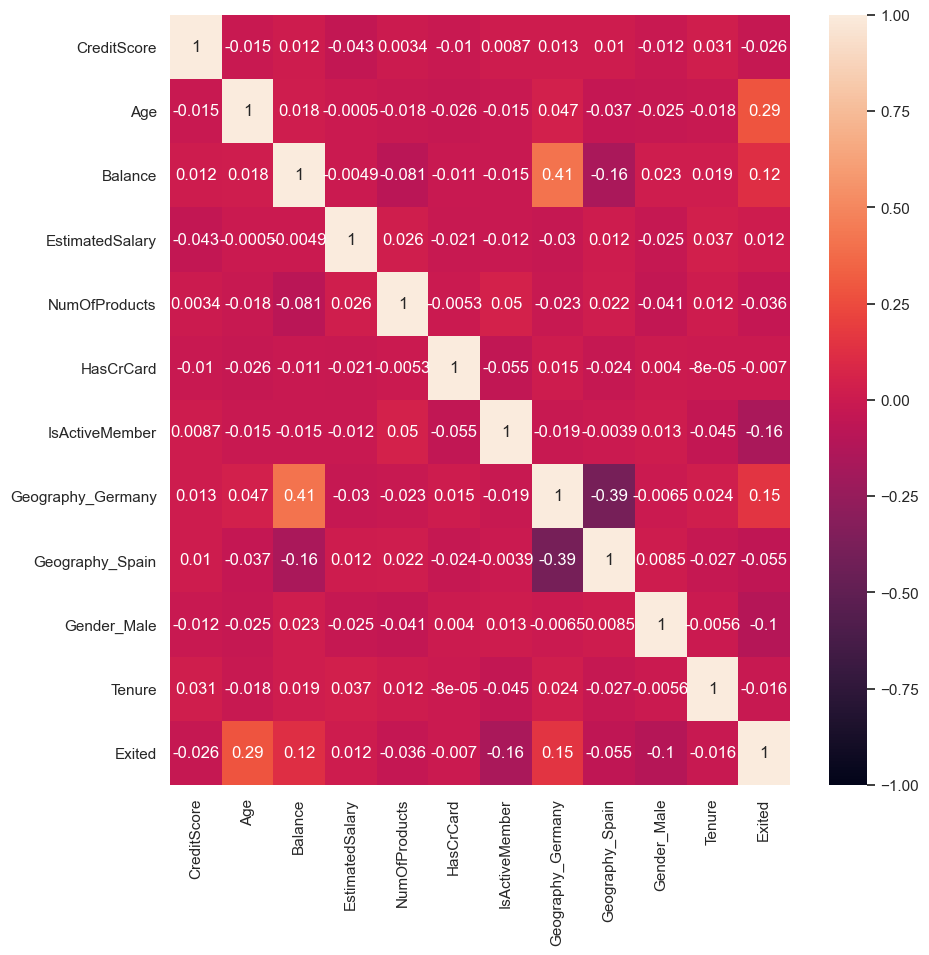

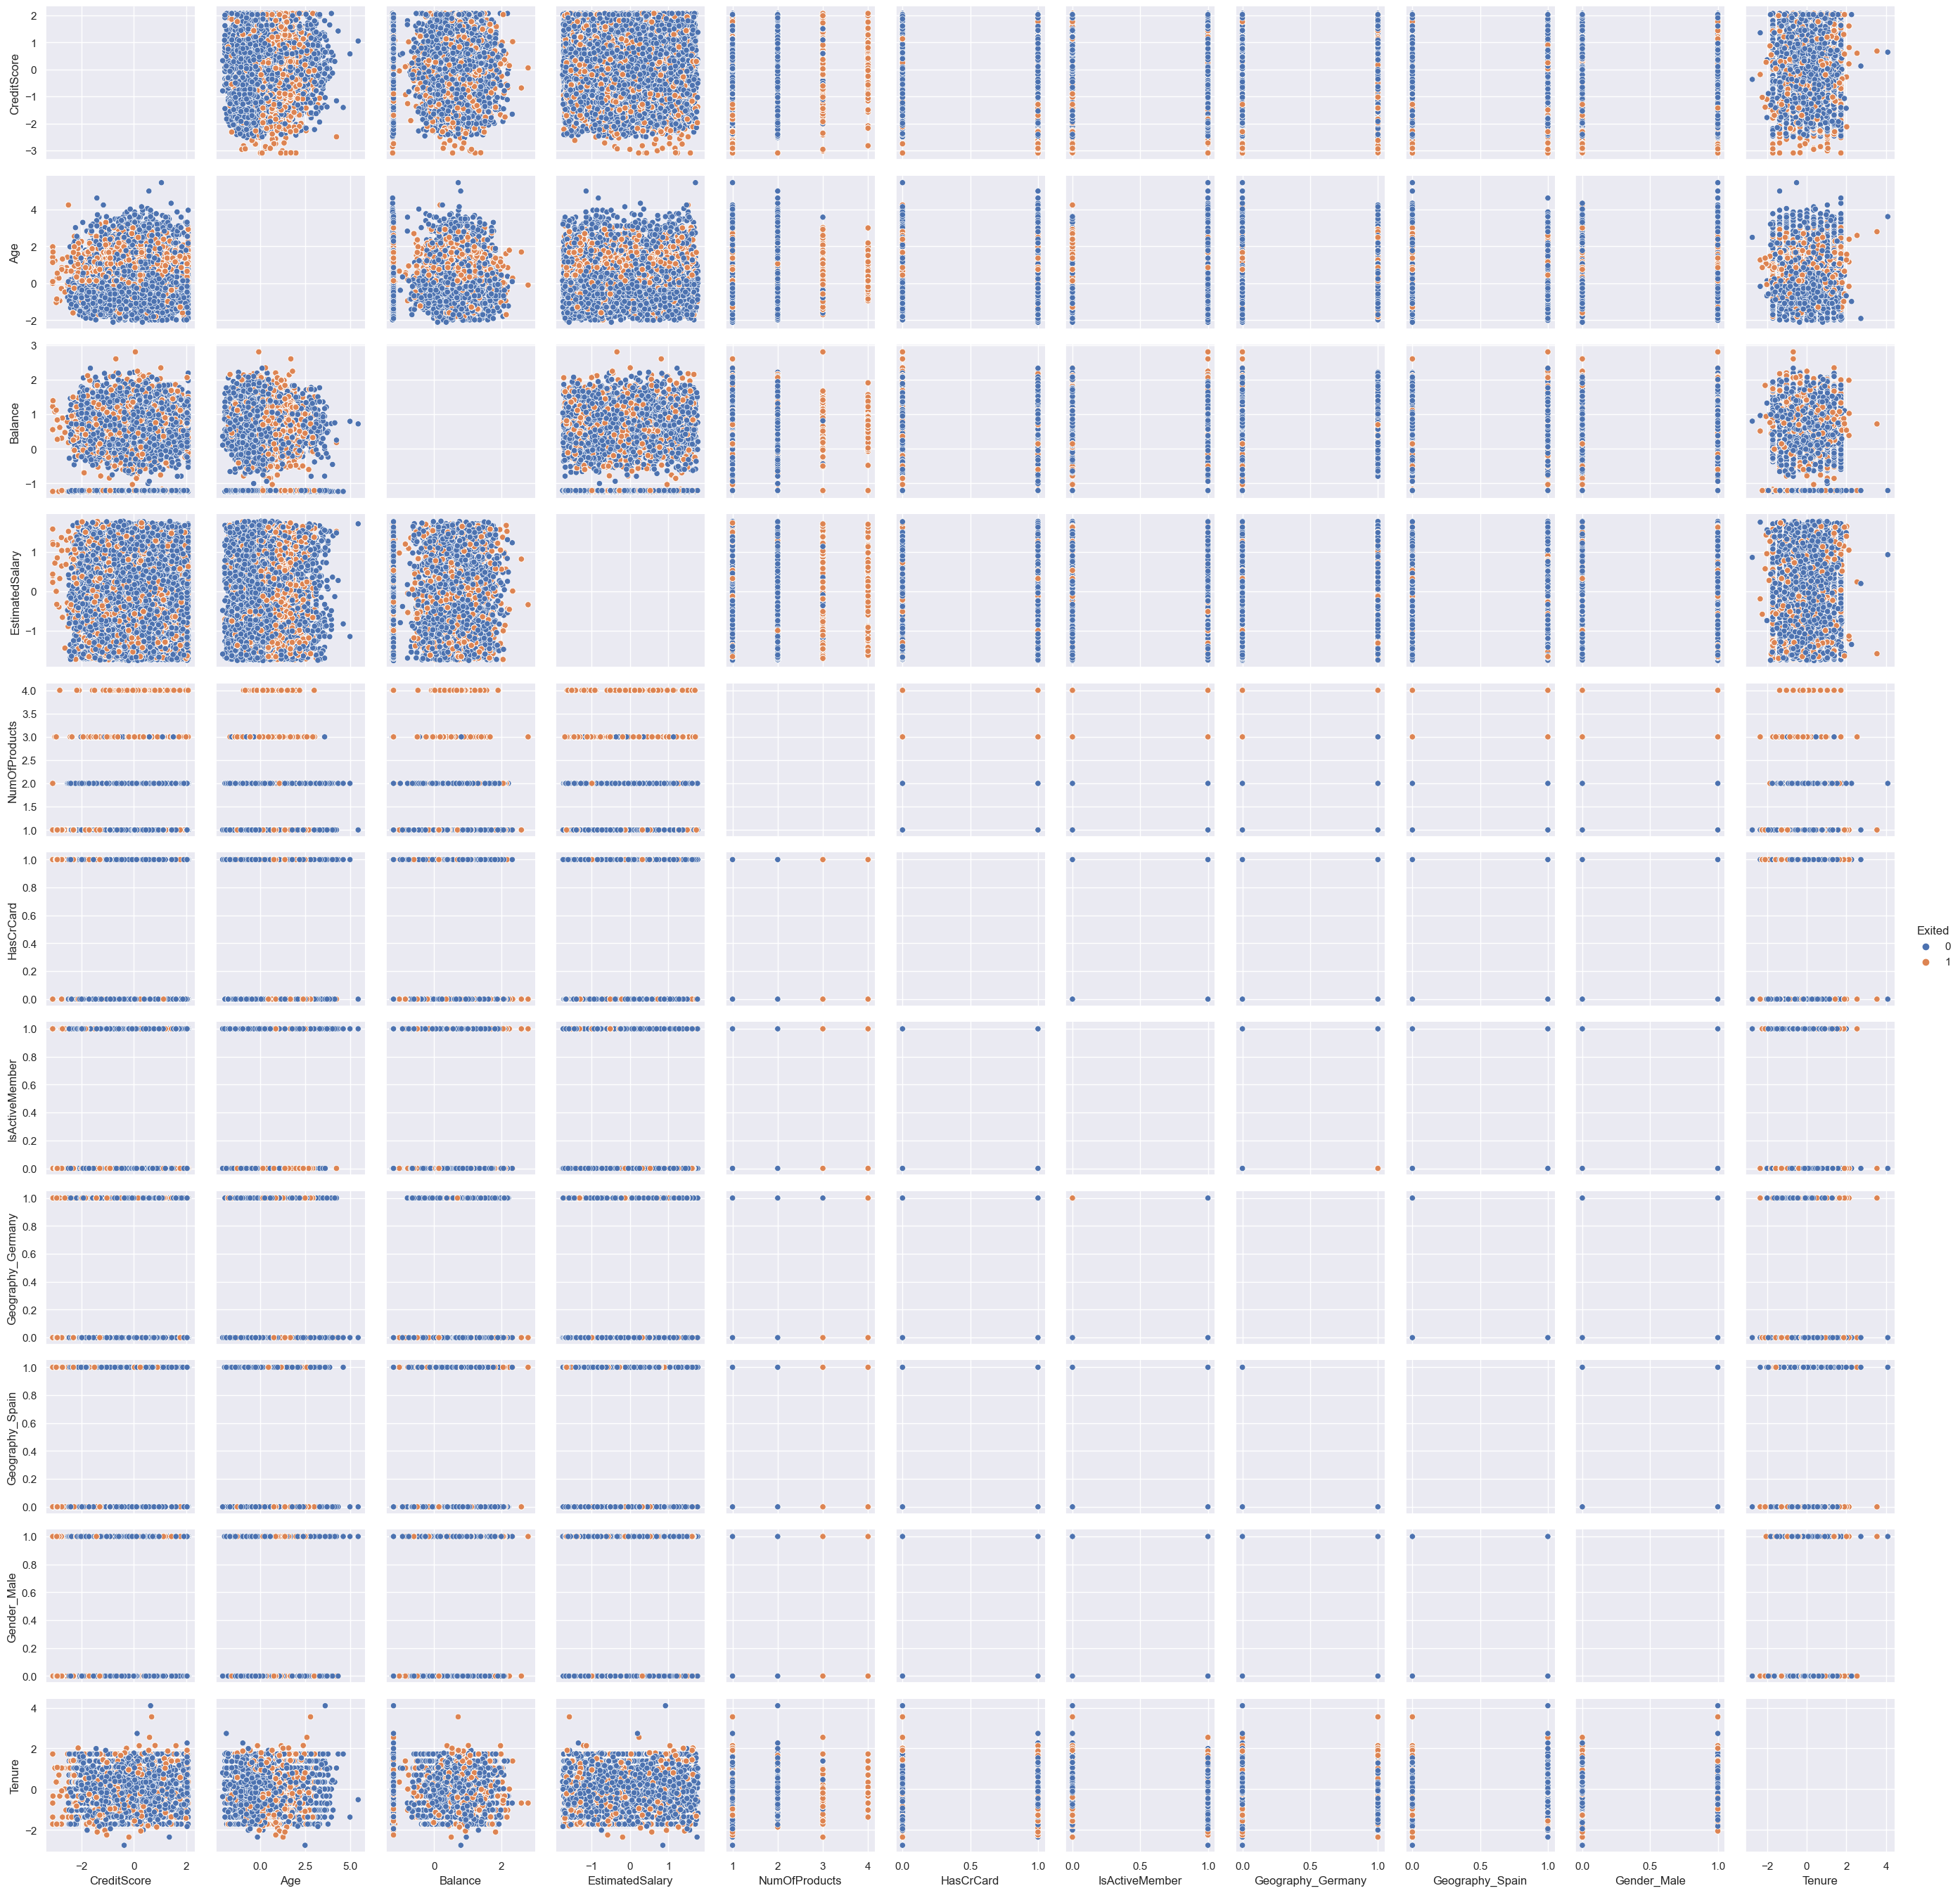

In [81]:
from sklearn.decomposition import PCA
from sklearn import mixture as mx
data2 = features_upsample.join(target_upsample)
pca = PCA(n_components = 5)
components = pd.DataFrame(pca.fit_transform(data2[data.columns[1:-1]]))
components["Exited"] = data2["Exited"].reset_index(drop = True)
ax = sns.heatmap(data2.corr(), vmin = -1, vmax = 1, annot = True)
sns.set(rc = {"figure.figsize" : (10, 10)})
plt.show()
#data2_x = data2.copy()
#data2_x = data2_x[data2_x.columns[1:]]
#gmm = mx.GaussianMixture(n_components = 25, covariance_type = "full").fit(data2_x)
#generated = gmm.sample(10000)
#gen = pd.DataFrame(generated[0])
#gen.rename(columns = {gen.columns[-1] : "Exited"}, inplace = True)
#gen.loc[gen["Exited"] >= 0.5, "Exited"] == 1
#gen.loc[gen["Exited"] < 0.5, "Exited"] == 0
g = sns.PairGrid(data2, hue = "Exited")
#g.map_diag()
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

Распределения мягко говоря - не очень. Я хотел, что-то сделать с этим, но боже, 10 часов ожидание, может я, что-то не то указал, подскажи если это так)

In [101]:
#Поделим новую таблицу на обучающую и валидационную выборки

#Отложим тестовую выборку
#features_test = features_upsample.tail(1000)
#features_upsample = features_upsample.head(14514)
#target_test = target_upsample.tail(1000)
#target_upsample = target_upsample.head(14514)

features_train, features_valid, target_train, target_valid = model_selection.train_test_split(features, target, 
                                                                                             test_size = 0.3, random_state = 12345)
#Отложим тестовую выборку
features_test = features_train.tail(1000)
features_train = features_train.head(6000)
target_test = target_train.tail(1000)
target_train = target_train.head(6000)

#Проверим какая техника бробьбы с дисбалансом лучше подходит для наших данных, для этого применим обе техники и позже проверим их
features_train_upsample, target_train_upsample = upsample(features_train, target_train, 4, True)
features_train_downsample, target_train_downsample = upsample(features_train, target_train, 0.25, False)

print(features_train_upsample.shape, features_train_downsample.shape)

print(target_train_upsample[target_train_upsample == 1].count())
print(target_train_downsample[target_train_downsample == 1].count())

print(features_train.shape, features_valid.shape, target_train.shape, target_valid.shape)

(9753, 11) (2438, 11)
5004
1251
(6000, 11) (3000, 11) (6000,) (3000,)


# Downsample

In [83]:
#xgb_model2 = xgb.XGBClassifier(random_state = 12345)
cat_model3 = cat.CatBoostClassifier(iterations = 614, min_data_in_leaf = 73, depth = 11, learning_rate = 0.3, 
                                    custom_loss = ["Accuracy", "F1"], grow_policy = "SymmetricTree", 
                                    leaf_estimation_backtracking = "AnyImprovement", 
                                   eval_metric = "F1", verbose = True, use_best_model = True, task_type = "GPU")

#cat_model4 = cat.CatBoostClassifier()

cat_model3.fit(features_train_downsample, target_train_downsample, eval_set = (features_valid, target_valid), early_stopping_rounds = 50, 
               plot = False)
xgb_model2.fit(features_train_downsample, target_train_downsample)

predict_xgb = xgb_model2.predict(features_valid)
predict_cat = cat_model3.predict(features_valid)

print("Accuracy xgb:", accuracy_score(target_valid, predict_xgb))
print("Accuracy cat:", accuracy_score(target_valid, predict_cat))
print("F1 score xgb:", f1_score(target_valid, predict_xgb))
print("F1 score cat:", f1_score(target_valid, predict_cat))
print("AUC-ROC xgb:", roc_auc_score(target_valid, predict_xgb))
print("AUC-ROC cat:", roc_auc_score(target_valid, predict_cat))
print("Confusion matrix xgb:", confusion_matrix(target_valid, predict_xgb))
print("Confusion matrix cat:", confusion_matrix(target_valid, predict_cat))

0:	learn: 0.7645907	test: 0.5293466	best: 0.5293466 (0)	total: 32.9ms	remaining: 20.2s
1:	learn: 0.7821044	test: 0.5827565	best: 0.5827565 (1)	total: 130ms	remaining: 39.7s
2:	learn: 0.7951020	test: 0.5785227	best: 0.5827565 (1)	total: 543ms	remaining: 1m 50s
3:	learn: 0.8034754	test: 0.5926876	best: 0.5926876 (3)	total: 570ms	remaining: 1m 26s
4:	learn: 0.7990115	test: 0.5983450	best: 0.5983450 (4)	total: 596ms	remaining: 1m 12s
5:	learn: 0.8037923	test: 0.5932095	best: 0.5983450 (4)	total: 673ms	remaining: 1m 8s
6:	learn: 0.8085809	test: 0.6089744	best: 0.6089744 (6)	total: 798ms	remaining: 1m 9s
7:	learn: 0.8113440	test: 0.6038217	best: 0.6089744 (6)	total: 833ms	remaining: 1m 3s
8:	learn: 0.8108553	test: 0.6052463	best: 0.6089744 (6)	total: 859ms	remaining: 57.8s
9:	learn: 0.8182191	test: 0.5982256	best: 0.6089744 (6)	total: 1.28s	remaining: 1m 17s
10:	learn: 0.8182191	test: 0.6010101	best: 0.6089744 (6)	total: 1.3s	remaining: 1m 11s
11:	learn: 0.8220859	test: 0.6012579	best: 0.608

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:50:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:50:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy xgb: 0.7153333333333334
Accuracy cat: 0.7966666666666666
F1 score xgb: 0.505787037037037
F1 score cat: 0.608974358974359
AUC-ROC xgb: 0.7174950577764543
AUC-ROC cat: 0.7918724203247394
Confusion matrix xgb: [[1709  685]
 [ 169  437]]
Confusion matrix cat: [[1915  479]
 [ 131  475]]


# Upsample

In [84]:
#xgb_model2 = xgb.XGBClassifier(random_state = 12345)
cat_model3 = cat.CatBoostClassifier(iterations = 614, min_data_in_leaf = 73, depth = 11, learning_rate = 0.3, 
                                    custom_loss = ["Accuracy", "F1"], grow_policy = "SymmetricTree", 
                                    leaf_estimation_backtracking = "AnyImprovement", 
                                   eval_metric = "Accuracy", verbose = True, use_best_model = True, task_type = "GPU")

#cat_model4 = cat.CatBoostClassifier()

cat_model3.fit(features_train_upsample, target_train_upsample, eval_set = (features_valid, target_valid), early_stopping_rounds = 50, 
               plot = False)
xgb_model2.fit(features_train_upsample, target_train_upsample)

predict_xgb = xgb_model2.predict(features_valid)
predict_cat = cat_model3.predict(features_valid)

print("Accuracy xgb:", accuracy_score(target_valid, predict_xgb))
print("Accuracy cat:", accuracy_score(target_valid, predict_cat))
print("F1 score xgb:", f1_score(target_valid, predict_xgb))
print("F1 score cat:", f1_score(target_valid, predict_cat))
print("AUC-ROC xgb:", roc_auc_score(target_valid, predict_xgb))
print("AUC-ROC cat:", roc_auc_score(target_valid, predict_cat))
print("Confusion matrix xgb:", confusion_matrix(target_valid, predict_xgb))
print("Confusion matrix cat:", confusion_matrix(target_valid, predict_cat))

0:	learn: 0.7649954	test: 0.7436667	best: 0.7436667 (0)	total: 41.5ms	remaining: 25.4s
1:	learn: 0.7911412	test: 0.7646667	best: 0.7646667 (1)	total: 524ms	remaining: 2m 40s
2:	learn: 0.8022147	test: 0.7776667	best: 0.7776667 (2)	total: 988ms	remaining: 3m 21s
3:	learn: 0.8081616	test: 0.7850000	best: 0.7850000 (3)	total: 1.47s	remaining: 3m 44s
4:	learn: 0.8187224	test: 0.7876667	best: 0.7876667 (4)	total: 1.93s	remaining: 3m 54s
5:	learn: 0.8241567	test: 0.7896667	best: 0.7896667 (5)	total: 2.39s	remaining: 4m 2s
6:	learn: 0.8239516	test: 0.7903333	best: 0.7903333 (6)	total: 2.47s	remaining: 3m 34s
7:	learn: 0.8241567	test: 0.7920000	best: 0.7920000 (7)	total: 2.5s	remaining: 3m 9s
8:	learn: 0.8276428	test: 0.7943333	best: 0.7943333 (8)	total: 2.95s	remaining: 3m 18s
9:	learn: 0.8275402	test: 0.7906667	best: 0.7943333 (8)	total: 3.04s	remaining: 3m 3s
10:	learn: 0.8321542	test: 0.7930000	best: 0.7943333 (8)	total: 3.49s	remaining: 3m 11s
11:	learn: 0.8356403	test: 0.7943333	best: 0.7

C:\Users\nefar\anaconda3\envs\LikeProject\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "three_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy xgb: 0.7726666666666666
Accuracy cat: 0.819
F1 score xgb: 0.5190409026798307
F1 score cat: 0.5932584269662922
AUC-ROC xgb: 0.7108985334623689
AUC-ROC cat: 0.7571838010868757
Confusion matrix xgb: [[1950  444]
 [ 238  368]]
Confusion matrix cat: [[2061  333]
 [ 210  396]]


# Upsample

Epoch 1/100
378/378 - 1s - loss: 0.5422 - accuracy: 0.7256 - val_loss: 0.4896 - val_accuracy: 0.7622
Epoch 2/100
378/378 - 0s - loss: 0.4761 - accuracy: 0.7684 - val_loss: 0.4653 - val_accuracy: 0.7753
Epoch 3/100
378/378 - 0s - loss: 0.4510 - accuracy: 0.7832 - val_loss: 0.4464 - val_accuracy: 0.7897
Epoch 4/100
378/378 - 0s - loss: 0.4371 - accuracy: 0.7939 - val_loss: 0.4653 - val_accuracy: 0.7746
Epoch 5/100
378/378 - 0s - loss: 0.4239 - accuracy: 0.7992 - val_loss: 0.4429 - val_accuracy: 0.7942
Epoch 6/100
378/378 - 0s - loss: 0.4150 - accuracy: 0.8104 - val_loss: 0.4309 - val_accuracy: 0.7937
Epoch 7/100
378/378 - 0s - loss: 0.4046 - accuracy: 0.8115 - val_loss: 0.4205 - val_accuracy: 0.8054
Epoch 8/100
378/378 - 0s - loss: 0.3958 - accuracy: 0.8183 - val_loss: 0.4240 - val_accuracy: 0.8034
Epoch 9/100
378/378 - 0s - loss: 0.3829 - accuracy: 0.8256 - val_loss: 0.4065 - val_accuracy: 0.8088
Epoch 10/100
378/378 - 0s - loss: 0.3733 - accuracy: 0.8331 - val_loss: 0.4547 - val_accura

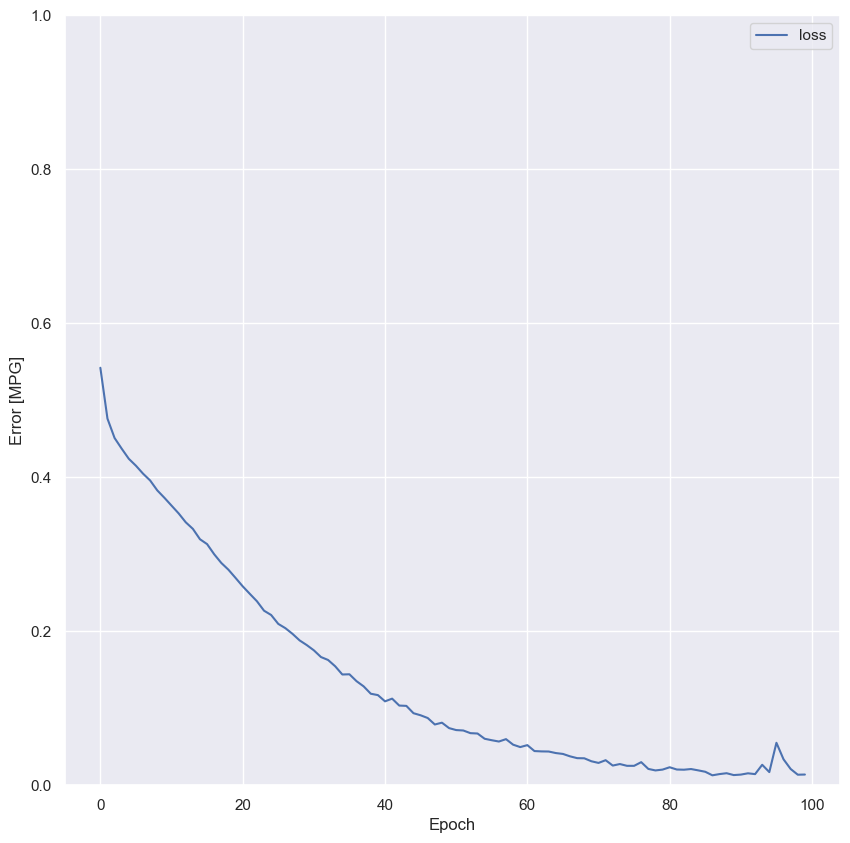

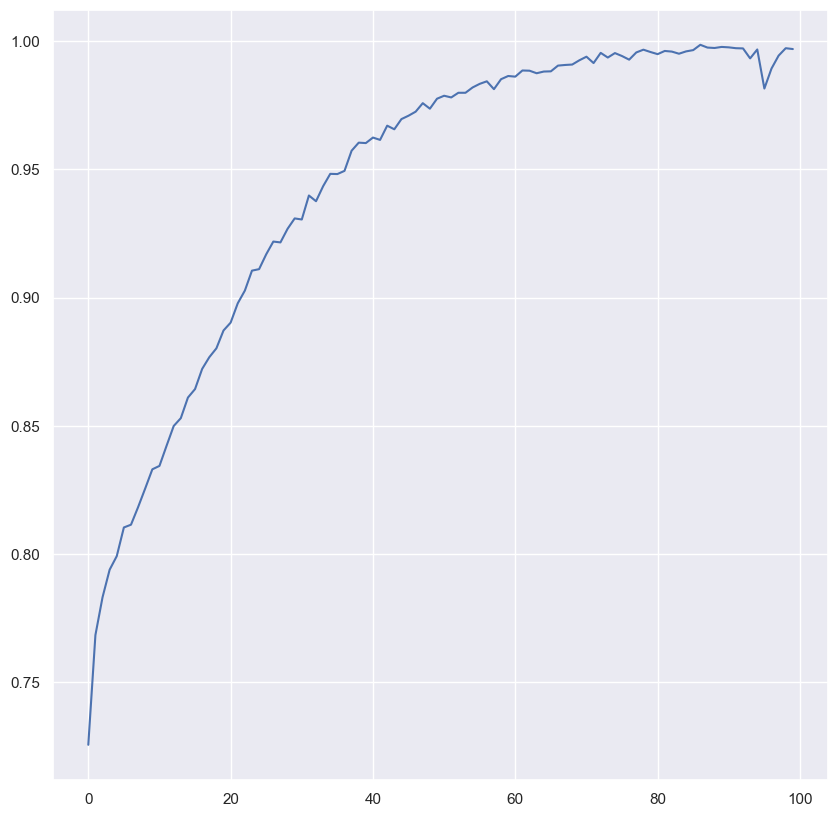

In [85]:
import tensorflow_addons as tfa
def build_model2():
    model = keras.Sequential([
        layers.Dense(264, activation = "relu"),
        layers.Dense(264, activation = "relu"),
        layers.Dense(1, activation = "sigmoid")
    ])
    
    model.compile(loss = "binary_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(amsgrad = True),
                  #optimizer = tf.keras.optimizers.RMSprop(0.0001),
                  metrics = ["accuracy"])
    return model

dnn_model_upsample = build_model2()
history2 = dnn_model_upsample.fit(features_upsample, target_upsample, validation_split = 0.25, verbose = 2, epochs = 100, shuffle = len(features_upsample))
results = dnn_model_upsample.evaluate(features_valid, target_valid, batch_size = len(features_valid))
#print(history2.history)
print(results)
plot_loss(history2, 1)
plt.show()
plt.plot(history2.history["accuracy"])
#plt.plot(history2.history["recall"])
#plt.plot(history2.history["precision"])
plt.show()

In [86]:
predict_dnn = dnn_model_upsample.predict(features_valid)
for i in range(len(predict_dnn)):
    predict_dnn[i] = np.round(predict_dnn[i])
    
    
#print(np.round(predict_dnn[0]))
print(predict_dnn)

#metric = tfa.metrics.F1Score(num_classes = len(predict_dnn))
print("F1 score:", f1_score(target_valid, predict_dnn))
print("AUC-ROC:", roc_auc_score(target_valid, predict_dnn))
print("Confusion matrix:", confusion_matrix(target_valid, predict_dnn))
#f1_score = 2 * (tf.compat.v2.metrics.recall(target_valid, predict_dnn))
#print("F1 score:", metric.update_state(target_valid, np.argmax(predict_dnn, axis = 1)).result())

[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
F1 score: 0.9278033794162827
AUC-ROC: 0.9791351315582685
Confusion matrix: [[2302   92]
 [   2  604]]


# Downsample

Epoch 1/100
95/95 - 1s - loss: 0.5912 - accuracy: 0.6955 - val_loss: 0.5654 - val_accuracy: 0.7090
Epoch 2/100
95/95 - 0s - loss: 0.5526 - accuracy: 0.7206 - val_loss: 0.5485 - val_accuracy: 0.7219
Epoch 3/100
95/95 - 0s - loss: 0.5280 - accuracy: 0.7438 - val_loss: 0.5294 - val_accuracy: 0.7279
Epoch 4/100
95/95 - 0s - loss: 0.5062 - accuracy: 0.7560 - val_loss: 0.5109 - val_accuracy: 0.7438
Epoch 5/100
95/95 - 0s - loss: 0.4830 - accuracy: 0.7703 - val_loss: 0.4998 - val_accuracy: 0.7428
Epoch 6/100
95/95 - 0s - loss: 0.4710 - accuracy: 0.7772 - val_loss: 0.5112 - val_accuracy: 0.7368
Epoch 7/100
95/95 - 0s - loss: 0.4640 - accuracy: 0.7766 - val_loss: 0.4992 - val_accuracy: 0.7507
Epoch 8/100
95/95 - 0s - loss: 0.4493 - accuracy: 0.7868 - val_loss: 0.4823 - val_accuracy: 0.7587
Epoch 9/100
95/95 - 0s - loss: 0.4362 - accuracy: 0.7928 - val_loss: 0.4916 - val_accuracy: 0.7478
Epoch 10/100
95/95 - 0s - loss: 0.4347 - accuracy: 0.7925 - val_loss: 0.4872 - val_accuracy: 0.7547
Epoch 11/

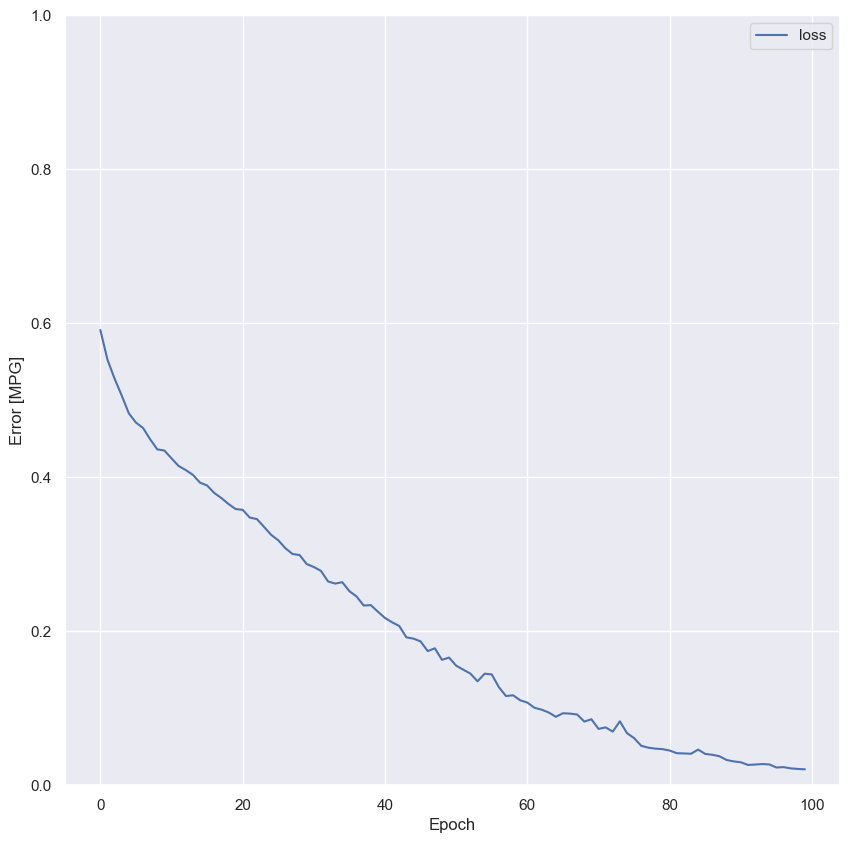

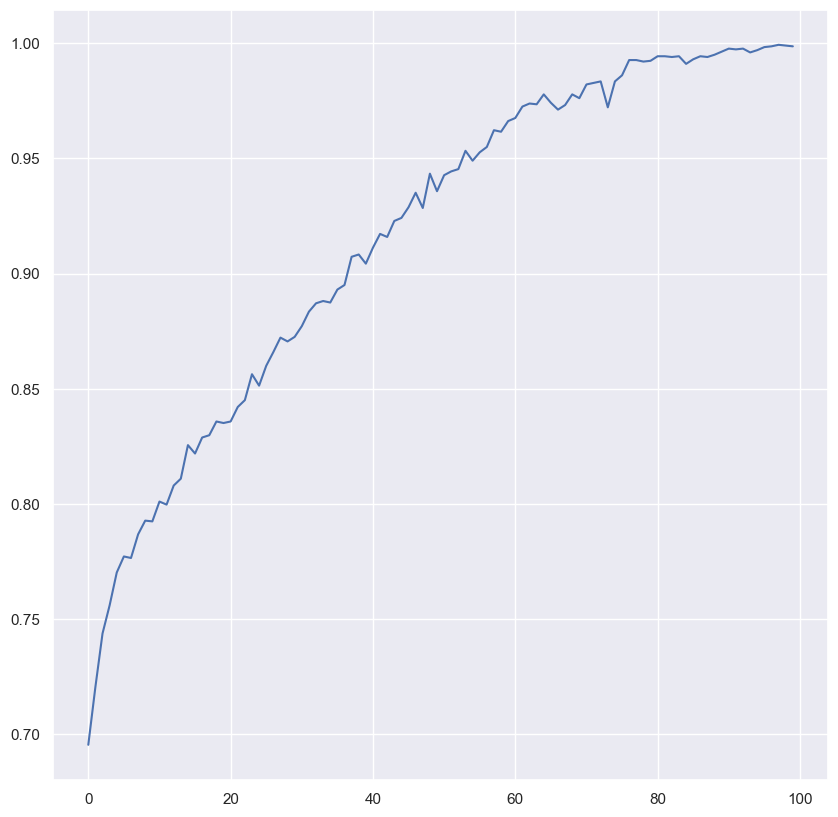

In [87]:
dnn_model_downsample = build_model2()
history2 = dnn_model_downsample.fit(features_downsample, target_downsample, validation_split = 0.25, verbose = 2, epochs = 100, shuffle = len(features_upsample))
results = dnn_model_downsample.evaluate(features_valid, target_valid, batch_size = len(features_valid))
#print(history2.history)
print(results)
plot_loss(history2, 1)
plt.show()
plt.plot(history2.history["accuracy"])
#plt.plot(history2.history["recall"])
#plt.plot(history2.history["precision"])
plt.show()

In [88]:
predict_dnn = dnn_model_downsample.predict(features_valid)
for i in range(len(predict_dnn)):
    predict_dnn[i] = np.round(predict_dnn[i])
    
    
#print(np.round(predict_dnn[0]))
print(predict_dnn)

#metric = tfa.metrics.F1Score(num_classes = len(predict_dnn))
print("F1 score:", f1_score(target_valid, predict_dnn))
print("AUC-ROC:", roc_auc_score(target_valid, predict_dnn))
print("Confusion matrix:", confusion_matrix(target_valid, predict_dnn))
#f1_score = 2 * (tf.compat.v2.metrics.recall(target_valid, predict_dnn))
#print("F1 score:", metric.update_state(target_valid, np.argmax(predict_dnn, axis = 1)).result())

[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
F1 score: 0.6514806378132119
AUC-ROC: 0.851228731895746
Confusion matrix: [[1816  578]
 [  34  572]]


Как видно из результатов - upsample показывает лучшие результаты точности, AUC-ROC и F1 меры. Поэтому используем её для

# Тестирование модели

In [89]:
predict_dnn = dnn_model_upsample.predict(features_test)
for i in range(len(predict_dnn)):
    predict_dnn[i] = np.round(predict_dnn[i])
    
    
#print(np.round(predict_dnn[0]))
print(predict_dnn)
print(features_test)
print(target_test.value_counts())

#metric = tfa.metrics.F1Score(num_classes = len(predict_dnn))
print(accuracy_score(target_test, predict_dnn))
print("F1 score:", f1_score(target_test, predict_dnn))
print("AUC-ROC:", roc_auc_score(target_test, predict_dnn))
print("Confusion matrix:", confusion_matrix(target_test, predict_dnn))

[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.

# Общий вывод:


1. Дисбаланс классов - это зло и с ним нужно бороться, избавляясь от него вы гаранитруете себе + 20 процентов точности минимум!)


2. Подбор гиперпараметров добавил 3-5 процентов точности моделям.


3. Без учета нейронной сети топ 3 модели для нашей задачи:

        3.1 1 место - CatBoost
          
        3.2 2 место - XGBoost
              
        3.3 3 место - SVC
        
        
4. Лучшие результаты показала нейронная сеть.